# DSCI-6011-03 Project-2


<center><h3>Title: Object Detection Using YOLOv5<br></h3>
</center>

<center><b>Team Members:<br>
• Raghavendra Akula<br>
• Vaishnavi Kukkala<br>
• Sai Charan Chandu Patla</b</center>

## Dataset

https://unhnewhaven-my.sharepoint.com/:f:/g/personal/vkukk2_unh_newhaven_edu/Ej0XXW0J73pDhC3VeDLSaqYB0ef6PNQpo079BhkbeO4SAA?e=t4MFGH

<h3>Import Libraries and Cloning Repository</h3>

In [ ]:
!git clone https://github.com/raghavaakula63/dl_project.git


Cloning into 'dl_project'...
remote: Enumerating objects: 1010, done.
remote: Total 1010 (delta 0), reused 0 (delta 0), pack-reused 1010 (from 1)
Receiving objects: 100% (1010/1010), 85.83 MiB | 10.59 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Updating files: 100% (1212/1212), done.


In [6]:
%cd dl_project

/content/dl_project


In [ ]:

"""
Train a YOLOv5 model on a custom dataset. Models and datasets download automatically from the latest YOLOv5 release.

Usage - Single-GPU training:
    $ python train.py --data coco128.yaml --weights yolov5s.pt --img 640  # from pretrained (recommended)
    $ python train.py --data coco128.yaml --weights '' --cfg yolov5s.yaml --img 640  # from scratch

Usage - Multi-GPU DDP training:
    $ python -m torch.distributed.run --nproc_per_node 4 --master_port 1 train.py --data coco128.yaml --weights yolov5s.pt --img 640 --device 0,1,2,3

Models:     https://github.com/ultralytics/yolov5/tree/master/models
Datasets:   https://github.com/ultralytics/yolov5/tree/master/data
Tutorial:   https://docs.ultralytics.com/yolov5/tutorials/train_custom_data
"""

import argparse
import math
import os
import random
import subprocess
import sys
import time
from copy import deepcopy
from datetime import datetime, timedelta
from pathlib import Path

try:
    import comet_ml  # must be imported before torch (if installed)
except ImportError:
    comet_ml = None

import numpy as np
import torch
import torch.distributed as dist
import torch.nn as nn
import yaml
from torch.optim import lr_scheduler
from tqdm import tqdm

FILE = Path(__file__).resolve()
ROOT = FILE.parents[0]  # YOLOv5 root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

import val as validate  # for end-of-epoch mAP
from models.experimental import attempt_load
from models.yolo import Model
from utils.autoanchor import check_anchors
from utils.autobatch import check_train_batch_size
from utils.callbacks import Callbacks
from utils.dataloaders import create_dataloader
from utils.downloads import attempt_download, is_url
from utils.general import (
    LOGGER,
    TQDM_BAR_FORMAT,
    check_amp,
    check_dataset,
    check_file,
    check_git_info,
    check_git_status,
    check_img_size,
    check_requirements,
    check_suffix,
    check_yaml,
    colorstr,
    get_latest_run,
    increment_path,
    init_seeds,
    intersect_dicts,
    labels_to_class_weights,
    labels_to_image_weights,
    methods,
    one_cycle,
    print_args,
    print_mutation,
    strip_optimizer,
    yaml_save,
)
from utils.loggers import LOGGERS, Loggers
from utils.loggers.comet.comet_utils import check_comet_resume
from utils.loss import ComputeLoss
from utils.metrics import fitness
from utils.plots import plot_evolve
from utils.torch_utils import (
    EarlyStopping,
    ModelEMA,
    de_parallel,
    select_device,
    smart_DDP,
    smart_optimizer,
    smart_resume,
    torch_distributed_zero_first,
)

LOCAL_RANK = int(os.getenv("LOCAL_RANK", -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv("RANK", -1))
WORLD_SIZE = int(os.getenv("WORLD_SIZE", 1))
GIT_INFO = check_git_info()


def train(hyp, opt, device, callbacks):
    """
    Train a YOLOv5 model on a custom dataset using specified hyperparameters, options, and device, managing datasets,
    model architecture, loss computation, and optimizer steps.

    Args:
        hyp (str | dict): Path to the hyperparameters YAML file or a dictionary of hyperparameters.
        opt (argparse.Namespace): Parsed command-line arguments containing training options.
        device (torch.device): Device on which training occurs, e.g., 'cuda' or 'cpu'.
        callbacks (Callbacks): Callback functions for various training events.

    Returns:
        None

    Models and datasets download automatically from the latest YOLOv5 release.

    Example:
        Single-GPU training:
        ```bash
        $ python train.py --data coco128.yaml --weights yolov5s.pt --img 640  # from pretrained (recommended)
        $ python train.py --data coco128.yaml --weights '' --cfg yolov5s.yaml --img 640  # from scratch
        ```

        Multi-GPU DDP training:
        ```bash
        $ python -m torch.distributed.run --nproc_per_node 4 --master_port 1 train.py --data coco128.yaml --weights
        yolov5s.pt --img 640 --device 0,1,2,3
        ```

        For more usage details, refer to:
        - Models: https://github.com/ultralytics/yolov5/tree/master/models
        - Datasets: https://github.com/ultralytics/yolov5/tree/master/data
        - Tutorial: https://docs.ultralytics.com/yolov5/tutorials/train_custom_data
    """
    save_dir, epochs, batch_size, weights, single_cls, evolve, data, cfg, resume, noval, nosave, workers, freeze = (
        Path(opt.save_dir),
        opt.epochs,
        opt.batch_size,
        opt.weights,
        opt.single_cls,
        opt.evolve,
        opt.data,
        opt.cfg,
        opt.resume,
        opt.noval,
        opt.nosave,
        opt.workers,
        opt.freeze,
    )
    callbacks.run("on_pretrain_routine_start")

    # Directories
    w = save_dir / "weights"  # weights dir
    (w.parent if evolve else w).mkdir(parents=True, exist_ok=True)  # make dir
    last, best = w / "last.pt", w / "best.pt"

    # Hyperparameters
    if isinstance(hyp, str):
        with open(hyp, errors="ignore") as f:
            hyp = yaml.safe_load(f)  # load hyps dict
    LOGGER.info(colorstr("hyperparameters: ") + ", ".join(f"{k}={v}" for k, v in hyp.items()))
    opt.hyp = hyp.copy()  # for saving hyps to checkpoints

    # Save run settings
    if not evolve:
        yaml_save(save_dir / "hyp.yaml", hyp)
        yaml_save(save_dir / "opt.yaml", vars(opt))

    # Loggers
    data_dict = None
    if RANK in {-1, 0}:
        include_loggers = list(LOGGERS)
        if getattr(opt, "ndjson_console", False):
            include_loggers.append("ndjson_console")
        if getattr(opt, "ndjson_file", False):
            include_loggers.append("ndjson_file")

        loggers = Loggers(
            save_dir=save_dir,
            weights=weights,
            opt=opt,
            hyp=hyp,
            logger=LOGGER,
            include=tuple(include_loggers),
        )

        # Register actions
        for k in methods(loggers):
            callbacks.register_action(k, callback=getattr(loggers, k))

        # Process custom dataset artifact link
        data_dict = loggers.remote_dataset
        if resume:  # If resuming runs from remote artifact
            weights, epochs, hyp, batch_size = opt.weights, opt.epochs, opt.hyp, opt.batch_size

    # Config
    plots = not evolve and not opt.noplots  # create plots
    cuda = device.type != "cpu"
    init_seeds(opt.seed + 1 + RANK, deterministic=True)
    with torch_distributed_zero_first(LOCAL_RANK):
        data_dict = data_dict or check_dataset(data)  # check if None
    train_path, val_path = data_dict["train"], data_dict["val"]
    nc = 1 if single_cls else int(data_dict["nc"])  # number of classes
    names = {0: "item"} if single_cls and len(data_dict["names"]) != 1 else data_dict["names"]  # class names
    is_coco = isinstance(val_path, str) and val_path.endswith("coco/val2017.txt")  # COCO dataset

    # Model
    check_suffix(weights, ".pt")  # check weights
    pretrained = weights.endswith(".pt")
    if pretrained:
        with torch_distributed_zero_first(LOCAL_RANK):
            weights = attempt_download(weights)  # download if not found locally
        ckpt = torch.load(weights, map_location="cpu")  # load checkpoint to CPU to avoid CUDA memory leak
        model = Model(cfg or ckpt["model"].yaml, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create
        exclude = ["anchor"] if (cfg or hyp.get("anchors")) and not resume else []  # exclude keys
        csd = ckpt["model"].float().state_dict()  # checkpoint state_dict as FP32
        csd = intersect_dicts(csd, model.state_dict(), exclude=exclude)  # intersect
        model.load_state_dict(csd, strict=False)  # load
        LOGGER.info(f"Transferred {len(csd)}/{len(model.state_dict())} items from {weights}")  # report
    else:
        model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create
    amp = check_amp(model)  # check AMP

    # Freeze
    freeze = [f"model.{x}." for x in (freeze if len(freeze) > 1 else range(freeze[0]))]  # layers to freeze
    for k, v in model.named_parameters():
        v.requires_grad = True  # train all layers
        # v.register_hook(lambda x: torch.nan_to_num(x))  # NaN to 0 (commented for erratic training results)
        if any(x in k for x in freeze):
            LOGGER.info(f"freezing {k}")
            v.requires_grad = False

    # Image size
    gs = max(int(model.stride.max()), 32)  # grid size (max stride)
    imgsz = check_img_size(opt.imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

    # Batch size
    if RANK == -1 and batch_size == -1:  # single-GPU only, estimate best batch size
        batch_size = check_train_batch_size(model, imgsz, amp)
        loggers.on_params_update({"batch_size": batch_size})

    # Optimizer
    nbs = 64  # nominal batch size
    accumulate = max(round(nbs / batch_size), 1)  # accumulate loss before optimizing
    hyp["weight_decay"] *= batch_size * accumulate / nbs  # scale weight_decay
    optimizer = smart_optimizer(model, opt.optimizer, hyp["lr0"], hyp["momentum"], hyp["weight_decay"])

    # Scheduler
    if opt.cos_lr:
        lf = one_cycle(1, hyp["lrf"], epochs)  # cosine 1->hyp['lrf']
    else:

        def lf(x):
            """Linear learning rate scheduler function with decay calculated by epoch proportion."""
            return (1 - x / epochs) * (1.0 - hyp["lrf"]) + hyp["lrf"]  # linear

    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)  # plot_lr_scheduler(optimizer, scheduler, epochs)

    # EMA
    ema = ModelEMA(model) if RANK in {-1, 0} else None

    # Resume
    best_fitness, start_epoch = 0.0, 0
    if pretrained:
        if resume:
            best_fitness, start_epoch, epochs = smart_resume(ckpt, optimizer, ema, weights, epochs, resume)
        del ckpt, csd

    # DP mode
    if cuda and RANK == -1 and torch.cuda.device_count() > 1:
        LOGGER.warning(
            "WARNING ⚠️ DP not recommended, use torch.distributed.run for best DDP Multi-GPU results.\n"
            "See Multi-GPU Tutorial at https://docs.ultralytics.com/yolov5/tutorials/multi_gpu_training to get started."
        )
        model = torch.nn.DataParallel(model)

    # SyncBatchNorm
    if opt.sync_bn and cuda and RANK != -1:
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model).to(device)
        LOGGER.info("Using SyncBatchNorm()")

    # Trainloader
    train_loader, dataset = create_dataloader(
        train_path,
        imgsz,
        batch_size // WORLD_SIZE,
        gs,
        single_cls,
        hyp=hyp,
        augment=True,
        cache=None if opt.cache == "val" else opt.cache,
        rect=opt.rect,
        rank=LOCAL_RANK,
        workers=workers,
        image_weights=opt.image_weights,
        quad=opt.quad,
        prefix=colorstr("train: "),
        shuffle=True,
        seed=opt.seed,
    )
    labels = np.concatenate(dataset.labels, 0)
    mlc = int(labels[:, 0].max())  # max label class
    assert mlc < nc, f"Label class {mlc} exceeds nc={nc} in {data}. Possible class labels are 0-{nc - 1}"

    # Process 0
    if RANK in {-1, 0}:
        val_loader = create_dataloader(
            val_path,
            imgsz,
            batch_size // WORLD_SIZE * 2,
            gs,
            single_cls,
            hyp=hyp,
            cache=None if noval else opt.cache,
            rect=True,
            rank=-1,
            workers=workers * 2,
            pad=0.5,
            prefix=colorstr("val: "),
        )[0]

        if not resume:
            if not opt.noautoanchor:
                check_anchors(dataset, model=model, thr=hyp["anchor_t"], imgsz=imgsz)  # run AutoAnchor
            model.half().float()  # pre-reduce anchor precision

        callbacks.run("on_pretrain_routine_end", labels, names)

    # DDP mode
    if cuda and RANK != -1:
        model = smart_DDP(model)

    # Model attributes
    nl = de_parallel(model).model[-1].nl  # number of detection layers (to scale hyps)
    hyp["box"] *= 3 / nl  # scale to layers
    hyp["cls"] *= nc / 80 * 3 / nl  # scale to classes and layers
    hyp["obj"] *= (imgsz / 640) ** 2 * 3 / nl  # scale to image size and layers
    hyp["label_smoothing"] = opt.label_smoothing
    model.nc = nc  # attach number of classes to model
    model.hyp = hyp  # attach hyperparameters to model
    model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device) * nc  # attach class weights
    model.names = names

    # Start training
    t0 = time.time()
    nb = len(train_loader)  # number of batches
    nw = max(round(hyp["warmup_epochs"] * nb), 100)  # number of warmup iterations, max(3 epochs, 100 iterations)
    # nw = min(nw, (epochs - start_epoch) / 2 * nb)  # limit warmup to < 1/2 of training
    last_opt_step = -1
    maps = np.zeros(nc)  # mAP per class
    results = (0, 0, 0, 0, 0, 0, 0)  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)
    scheduler.last_epoch = start_epoch - 1  # do not move
    scaler = torch.cuda.amp.GradScaler(enabled=amp)
    stopper, stop = EarlyStopping(patience=opt.patience), False
    compute_loss = ComputeLoss(model)  # init loss class
    callbacks.run("on_train_start")
    LOGGER.info(
        f'Image sizes {imgsz} train, {imgsz} val\n'
        f'Using {train_loader.num_workers * WORLD_SIZE} dataloader workers\n'
        f"Logging results to {colorstr('bold', save_dir)}\n"
        f'Starting training for {epochs} epochs...'
    )
    for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
        callbacks.run("on_train_epoch_start")
        model.train()

        # Update image weights (optional, single-GPU only)
        if opt.image_weights:
            cw = model.class_weights.cpu().numpy() * (1 - maps) ** 2 / nc  # class weights
            iw = labels_to_image_weights(dataset.labels, nc=nc, class_weights=cw)  # image weights
            dataset.indices = random.choices(range(dataset.n), weights=iw, k=dataset.n)  # rand weighted idx

        # Update mosaic border (optional)
        # b = int(random.uniform(0.25 * imgsz, 0.75 * imgsz + gs) // gs * gs)
        # dataset.mosaic_border = [b - imgsz, -b]  # height, width borders

        mloss = torch.zeros(3, device=device)  # mean losses
        if RANK != -1:
            train_loader.sampler.set_epoch(epoch)
        pbar = enumerate(train_loader)
        LOGGER.info(("\n" + "%11s" * 7) % ("Epoch", "GPU_mem", "box_loss", "obj_loss", "cls_loss", "Instances", "Size"))
        if RANK in {-1, 0}:
            pbar = tqdm(pbar, total=nb, bar_format=TQDM_BAR_FORMAT)  # progress bar
        optimizer.zero_grad()
        for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
            callbacks.run("on_train_batch_start")
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device, non_blocking=True).float() / 255  # uint8 to float32, 0-255 to 0.0-1.0

            # Warmup
            if ni <= nw:
                xi = [0, nw]  # x interp
                # compute_loss.gr = np.interp(ni, xi, [0.0, 1.0])  # iou loss ratio (obj_loss = 1.0 or iou)
                accumulate = max(1, np.interp(ni, xi, [1, nbs / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x["lr"] = np.interp(ni, xi, [hyp["warmup_bias_lr"] if j == 0 else 0.0, x["initial_lr"] * lf(epoch)])
                    if "momentum" in x:
                        x["momentum"] = np.interp(ni, xi, [hyp["warmup_momentum"], hyp["momentum"]])

            # Multi-scale
            if opt.multi_scale:
                sz = random.randrange(int(imgsz * 0.5), int(imgsz * 1.5) + gs) // gs * gs  # size
                sf = sz / max(imgs.shape[2:])  # scale factor
                if sf != 1:
                    ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to gs-multiple)
                    imgs = nn.functional.interpolate(imgs, size=ns, mode="bilinear", align_corners=False)

            # Forward
            with torch.cuda.amp.autocast(amp):
                pred = model(imgs)  # forward
                loss, loss_items = compute_loss(pred, targets.to(device))  # loss scaled by batch_size
                if RANK != -1:
                    loss *= WORLD_SIZE  # gradient averaged between devices in DDP mode
                if opt.quad:
                    loss *= 4.0

            # Backward
            scaler.scale(loss).backward()

            # Optimize - https://pytorch.org/docs/master/notes/amp_examples.html
            if ni - last_opt_step >= accumulate:
                scaler.unscale_(optimizer)  # unscale gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # clip gradients
                scaler.step(optimizer)  # optimizer.step
                scaler.update()
                optimizer.zero_grad()
                if ema:
                    ema.update(model)
                last_opt_step = ni

            # Log
            if RANK in {-1, 0}:
                mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
                mem = f"{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G"  # (GB)
                pbar.set_description(
                    ("%11s" * 2 + "%11.4g" * 5)
                    % (f"{epoch}/{epochs - 1}", mem, *mloss, targets.shape[0], imgs.shape[-1])
                )
                callbacks.run("on_train_batch_end", model, ni, imgs, targets, paths, list(mloss))
                if callbacks.stop_training:
                    return
            # end batch ------------------------------------------------------------------------------------------------

        # Scheduler
        lr = [x["lr"] for x in optimizer.param_groups]  # for loggers
        scheduler.step()

        if RANK in {-1, 0}:
            # mAP
            callbacks.run("on_train_epoch_end", epoch=epoch)
            ema.update_attr(model, include=["yaml", "nc", "hyp", "names", "stride", "class_weights"])
            final_epoch = (epoch + 1 == epochs) or stopper.possible_stop
            if not noval or final_epoch:  # Calculate mAP
                results, maps, _ = validate.run(
                    data_dict,
                    batch_size=batch_size // WORLD_SIZE * 2,
                    imgsz=imgsz,
                    half=amp,
                    model=ema.ema,
                    single_cls=single_cls,
                    dataloader=val_loader,
                    save_dir=save_dir,
                    plots=False,
                    callbacks=callbacks,
                    compute_loss=compute_loss,
                )

            # Update best mAP
            fi = fitness(np.array(results).reshape(1, -1))  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            stop = stopper(epoch=epoch, fitness=fi)  # early stop check
            if fi > best_fitness:
                best_fitness = fi
            log_vals = list(mloss) + list(results) + lr
            callbacks.run("on_fit_epoch_end", log_vals, epoch, best_fitness, fi)

            # Save model
            if (not nosave) or (final_epoch and not evolve):  # if save
                ckpt = {
                    "epoch": epoch,
                    "best_fitness": best_fitness,
                    "model": deepcopy(de_parallel(model)).half(),
                    "ema": deepcopy(ema.ema).half(),
                    "updates": ema.updates,
                    "optimizer": optimizer.state_dict(),
                    "opt": vars(opt),
                    "git": GIT_INFO,  # {remote, branch, commit} if a git repo
                    "date": datetime.now().isoformat(),
                }

                # Save last, best and delete
                torch.save(ckpt, last)
                if best_fitness == fi:
                    torch.save(ckpt, best)
                if opt.save_period > 0 and epoch % opt.save_period == 0:
                    torch.save(ckpt, w / f"epoch{epoch}.pt")
                del ckpt
                callbacks.run("on_model_save", last, epoch, final_epoch, best_fitness, fi)

        # EarlyStopping
        if RANK != -1:  # if DDP training
            broadcast_list = [stop if RANK == 0 else None]
            dist.broadcast_object_list(broadcast_list, 0)  # broadcast 'stop' to all ranks
            if RANK != 0:
                stop = broadcast_list[0]
        if stop:
            break  # must break all DDP ranks

        # end epoch ----------------------------------------------------------------------------------------------------
    # end training -----------------------------------------------------------------------------------------------------
    if RANK in {-1, 0}:
        LOGGER.info(f"\n{epoch - start_epoch + 1} epochs completed in {(time.time() - t0) / 3600:.3f} hours.")
        for f in last, best:
            if f.exists():
                strip_optimizer(f)  # strip optimizers
                if f is best:
                    LOGGER.info(f"\nValidating {f}...")
                    results, _, _ = validate.run(
                        data_dict,
                        batch_size=batch_size // WORLD_SIZE * 2,
                        imgsz=imgsz,
                        model=attempt_load(f, device).half(),
                        iou_thres=0.65 if is_coco else 0.60,  # best pycocotools at iou 0.65
                        single_cls=single_cls,
                        dataloader=val_loader,
                        save_dir=save_dir,
                        save_json=is_coco,
                        verbose=True,
                        plots=plots,
                        callbacks=callbacks,
                        compute_loss=compute_loss,
                    )  # val best model with plots
                    if is_coco:
                        callbacks.run("on_fit_epoch_end", list(mloss) + list(results) + lr, epoch, best_fitness, fi)

        callbacks.run("on_train_end", last, best, epoch, results)

    torch.cuda.empty_cache()
    return results


def parse_opt(known=False):
    """
    Parse command-line arguments for YOLOv5 training, validation, and testing.

    Args:
        known (bool, optional): If True, parses known arguments, ignoring the unknown. Defaults to False.

    Returns:
        (argparse.Namespace): Parsed command-line arguments containing options for YOLOv5 execution.

    Example:
        ```python
        from ultralytics.yolo import parse_opt
        opt = parse_opt()
        print(opt)
        ```

    Links:
        - Models: https://github.com/ultralytics/yolov5/tree/master/models
        - Datasets: https://github.com/ultralytics/yolov5/tree/master/data
        - Tutorial: https://docs.ultralytics.com/yolov5/tutorials/train_custom_data
    """
    parser = argparse.ArgumentParser()
    parser.add_argument("--weights", type=str, default=ROOT / "yolov5s.pt", help="initial weights path")
    parser.add_argument("--cfg", type=str, default="", help="model.yaml path")
    parser.add_argument("--data", type=str, default=ROOT / "data/coco128.yaml", help="dataset.yaml path")
    parser.add_argument("--hyp", type=str, default=ROOT / "data/hyps/hyp.scratch-low.yaml", help="hyperparameters path")
    parser.add_argument("--epochs", type=int, default=100, help="total training epochs")
    parser.add_argument("--batch-size", type=int, default=16, help="total batch size for all GPUs, -1 for autobatch")
    parser.add_argument("--imgsz", "--img", "--img-size", type=int, default=640, help="train, val image size (pixels)")
    parser.add_argument("--rect", action="store_true", help="rectangular training")
    parser.add_argument("--resume", nargs="?", const=True, default=False, help="resume most recent training")
    parser.add_argument("--nosave", action="store_true", help="only save final checkpoint")
    parser.add_argument("--noval", action="store_true", help="only validate final epoch")
    parser.add_argument("--noautoanchor", action="store_true", help="disable AutoAnchor")
    parser.add_argument("--noplots", action="store_true", help="save no plot files")
    parser.add_argument("--evolve", type=int, nargs="?", const=300, help="evolve hyperparameters for x generations")
    parser.add_argument(
        "--evolve_population", type=str, default=ROOT / "data/hyps", help="location for loading population"
    )
    parser.add_argument("--resume_evolve", type=str, default=None, help="resume evolve from last generation")
    parser.add_argument("--bucket", type=str, default="", help="gsutil bucket")
    parser.add_argument("--cache", type=str, nargs="?", const="ram", help="image --cache ram/disk")
    parser.add_argument("--image-weights", action="store_true", help="use weighted image selection for training")
    parser.add_argument("--device", default="", help="cuda device, i.e. 0 or 0,1,2,3 or cpu")
    parser.add_argument("--multi-scale", action="store_true", help="vary img-size +/- 50%%")
    parser.add_argument("--single-cls", action="store_true", help="train multi-class data as single-class")
    parser.add_argument("--optimizer", type=str, choices=["SGD", "Adam", "AdamW"], default="SGD", help="optimizer")
    parser.add_argument("--sync-bn", action="store_true", help="use SyncBatchNorm, only available in DDP mode")
    parser.add_argument("--workers", type=int, default=8, help="max dataloader workers (per RANK in DDP mode)")
    parser.add_argument("--project", default=ROOT / "runs/train", help="save to project/name")
    parser.add_argument("--name", default="exp", help="save to project/name")
    parser.add_argument("--exist-ok", action="store_true", help="existing project/name ok, do not increment")
    parser.add_argument("--quad", action="store_true", help="quad dataloader")
    parser.add_argument("--cos-lr", action="store_true", help="cosine LR scheduler")
    parser.add_argument("--label-smoothing", type=float, default=0.0, help="Label smoothing epsilon")
    parser.add_argument("--patience", type=int, default=100, help="EarlyStopping patience (epochs without improvement)")
    parser.add_argument("--freeze", nargs="+", type=int, default=[0], help="Freeze layers: backbone=10, first3=0 1 2")
    parser.add_argument("--save-period", type=int, default=-1, help="Save checkpoint every x epochs (disabled if < 1)")
    parser.add_argument("--seed", type=int, default=0, help="Global training seed")
    parser.add_argument("--local_rank", type=int, default=-1, help="Automatic DDP Multi-GPU argument, do not modify")

    # Logger arguments
    parser.add_argument("--entity", default=None, help="Entity")
    parser.add_argument("--upload_dataset", nargs="?", const=True, default=False, help='Upload data, "val" option')
    parser.add_argument("--bbox_interval", type=int, default=-1, help="Set bounding-box image logging interval")
    parser.add_argument("--artifact_alias", type=str, default="latest", help="Version of dataset artifact to use")

    # NDJSON logging
    parser.add_argument("--ndjson-console", action="store_true", help="Log ndjson to console")
    parser.add_argument("--ndjson-file", action="store_true", help="Log ndjson to file")

    return parser.parse_known_args()[0] if known else parser.parse_args()


def main(opt, callbacks=Callbacks()):
    """
    Runs the main entry point for training or hyperparameter evolution with specified options and optional callbacks.

    Args:
        opt (argparse.Namespace): The command-line arguments parsed for YOLOv5 training and evolution.
        callbacks (ultralytics.utils.callbacks.Callbacks, optional): Callback functions for various training stages.
            Defaults to Callbacks().

    Returns:
        None

    Note:
        For detailed usage, refer to:
        https://github.com/ultralytics/yolov5/tree/master/models
    """
    if RANK in {-1, 0}:
        print_args(vars(opt))
        check_git_status()
        check_requirements(ROOT / "requirements.txt")

    # Resume (from specified or most recent last.pt)
    if opt.resume and not check_comet_resume(opt) and not opt.evolve:
        last = Path(check_file(opt.resume) if isinstance(opt.resume, str) else get_latest_run())
        opt_yaml = last.parent.parent / "opt.yaml"  # train options yaml
        opt_data = opt.data  # original dataset
        if opt_yaml.is_file():
            with open(opt_yaml, errors="ignore") as f:
                d = yaml.safe_load(f)
        else:
            d = torch.load(last, map_location="cpu")["opt"]
        opt = argparse.Namespace(**d)  # replace
        opt.cfg, opt.weights, opt.resume = "", str(last), True  # reinstate
        if is_url(opt_data):
            opt.data = check_file(opt_data)  # avoid HUB resume auth timeout
    else:
        opt.data, opt.cfg, opt.hyp, opt.weights, opt.project = (
            check_file(opt.data),
            check_yaml(opt.cfg),
            check_yaml(opt.hyp),
            str(opt.weights),
            str(opt.project),
        )  # checks
        assert len(opt.cfg) or len(opt.weights), "either --cfg or --weights must be specified"
        if opt.evolve:
            if opt.project == str(ROOT / "runs/train"):  # if default project name, rename to runs/evolve
                opt.project = str(ROOT / "runs/evolve")
            opt.exist_ok, opt.resume = opt.resume, False  # pass resume to exist_ok and disable resume
        if opt.name == "cfg":
            opt.name = Path(opt.cfg).stem  # use model.yaml as name
        opt.save_dir = str(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))

    # DDP mode
    device = select_device(opt.device, batch_size=opt.batch_size)
    if LOCAL_RANK != -1:
        msg = "is not compatible with YOLOv5 Multi-GPU DDP training"
        assert not opt.image_weights, f"--image-weights {msg}"
        assert not opt.evolve, f"--evolve {msg}"
        assert opt.batch_size != -1, f"AutoBatch with --batch-size -1 {msg}, please pass a valid --batch-size"
        assert opt.batch_size % WORLD_SIZE == 0, f"--batch-size {opt.batch_size} must be multiple of WORLD_SIZE"
        assert torch.cuda.device_count() > LOCAL_RANK, "insufficient CUDA devices for DDP command"
        torch.cuda.set_device(LOCAL_RANK)
        device = torch.device("cuda", LOCAL_RANK)
        dist.init_process_group(
            backend="nccl" if dist.is_nccl_available() else "gloo", timeout=timedelta(seconds=10800)
        )

    # Train
    if not opt.evolve:
        train(opt.hyp, opt, device, callbacks)

    # Evolve hyperparameters (optional)
    else:
        # Hyperparameter evolution metadata (including this hyperparameter True-False, lower_limit, upper_limit)
        meta = {
            "lr0": (False, 1e-5, 1e-1),  # initial learning rate (SGD=1E-2, Adam=1E-3)
            "lrf": (False, 0.01, 1.0),  # final OneCycleLR learning rate (lr0 * lrf)
            "momentum": (False, 0.6, 0.98),  # SGD momentum/Adam beta1
            "weight_decay": (False, 0.0, 0.001),  # optimizer weight decay
            "warmup_epochs": (False, 0.0, 5.0),  # warmup epochs (fractions ok)
            "warmup_momentum": (False, 0.0, 0.95),  # warmup initial momentum
            "warmup_bias_lr": (False, 0.0, 0.2),  # warmup initial bias lr
            "box": (False, 0.02, 0.2),  # box loss gain
            "cls": (False, 0.2, 4.0),  # cls loss gain
            "cls_pw": (False, 0.5, 2.0),  # cls BCELoss positive_weight
            "obj": (False, 0.2, 4.0),  # obj loss gain (scale with pixels)
            "obj_pw": (False, 0.5, 2.0),  # obj BCELoss positive_weight
            "iou_t": (False, 0.1, 0.7),  # IoU training threshold
            "anchor_t": (False, 2.0, 8.0),  # anchor-multiple threshold
            "anchors": (False, 2.0, 10.0),  # anchors per output grid (0 to ignore)
            "fl_gamma": (False, 0.0, 2.0),  # focal loss gamma (efficientDet default gamma=1.5)
            "hsv_h": (True, 0.0, 0.1),  # image HSV-Hue augmentation (fraction)
            "hsv_s": (True, 0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
            "hsv_v": (True, 0.0, 0.9),  # image HSV-Value augmentation (fraction)
            "degrees": (True, 0.0, 45.0),  # image rotation (+/- deg)
            "translate": (True, 0.0, 0.9),  # image translation (+/- fraction)
            "scale": (True, 0.0, 0.9),  # image scale (+/- gain)
            "shear": (True, 0.0, 10.0),  # image shear (+/- deg)
            "perspective": (True, 0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
            "flipud": (True, 0.0, 1.0),  # image flip up-down (probability)
            "fliplr": (True, 0.0, 1.0),  # image flip left-right (probability)
            "mosaic": (True, 0.0, 1.0),  # image mosaic (probability)
            "mixup": (True, 0.0, 1.0),  # image mixup (probability)
            "copy_paste": (True, 0.0, 1.0),  # segment copy-paste (probability)
        }

        # GA configs
        pop_size = 50
        mutation_rate_min = 0.01
        mutation_rate_max = 0.5
        crossover_rate_min = 0.5
        crossover_rate_max = 1
        min_elite_size = 2
        max_elite_size = 5
        tournament_size_min = 2
        tournament_size_max = 10

        with open(opt.hyp, errors="ignore") as f:
            hyp = yaml.safe_load(f)  # load hyps dict
            if "anchors" not in hyp:  # anchors commented in hyp.yaml
                hyp["anchors"] = 3
        if opt.noautoanchor:
            del hyp["anchors"], meta["anchors"]
        opt.noval, opt.nosave, save_dir = True, True, Path(opt.save_dir)  # only val/save final epoch
        # ei = [isinstance(x, (int, float)) for x in hyp.values()]  # evolvable indices
        evolve_yaml, evolve_csv = save_dir / "hyp_evolve.yaml", save_dir / "evolve.csv"
        if opt.bucket:
            # download evolve.csv if exists
            subprocess.run(
                [
                    "gsutil",
                    "cp",
                    f"gs://{opt.bucket}/evolve.csv",
                    str(evolve_csv),
                ]
            )

        # Delete the items in meta dictionary whose first value is False
        del_ = [item for item, value_ in meta.items() if value_[0] is False]
        hyp_GA = hyp.copy()  # Make a copy of hyp dictionary
        for item in del_:
            del meta[item]  # Remove the item from meta dictionary
            del hyp_GA[item]  # Remove the item from hyp_GA dictionary

        # Set lower_limit and upper_limit arrays to hold the search space boundaries
        lower_limit = np.array([meta[k][1] for k in hyp_GA.keys()])
        upper_limit = np.array([meta[k][2] for k in hyp_GA.keys()])

        # Create gene_ranges list to hold the range of values for each gene in the population
        gene_ranges = [(lower_limit[i], upper_limit[i]) for i in range(len(upper_limit))]

        # Initialize the population with initial_values or random values
        initial_values = []

        # If resuming evolution from a previous checkpoint
        if opt.resume_evolve is not None:
            assert os.path.isfile(ROOT / opt.resume_evolve), "evolve population path is wrong!"
            with open(ROOT / opt.resume_evolve, errors="ignore") as f:
                evolve_population = yaml.safe_load(f)
                for value in evolve_population.values():
                    value = np.array([value[k] for k in hyp_GA.keys()])
                    initial_values.append(list(value))

        # If not resuming from a previous checkpoint, generate initial values from .yaml files in opt.evolve_population
        else:
            yaml_files = [f for f in os.listdir(opt.evolve_population) if f.endswith(".yaml")]
            for file_name in yaml_files:
                with open(os.path.join(opt.evolve_population, file_name)) as yaml_file:
                    value = yaml.safe_load(yaml_file)
                    value = np.array([value[k] for k in hyp_GA.keys()])
                    initial_values.append(list(value))

        # Generate random values within the search space for the rest of the population
        if initial_values is None:
            population = [generate_individual(gene_ranges, len(hyp_GA)) for _ in range(pop_size)]
        elif pop_size > 1:
            population = [generate_individual(gene_ranges, len(hyp_GA)) for _ in range(pop_size - len(initial_values))]
            for initial_value in initial_values:
                population = [initial_value] + population

        # Run the genetic algorithm for a fixed number of generations
        list_keys = list(hyp_GA.keys())
        for generation in range(opt.evolve):
            if generation >= 1:
                save_dict = {}
                for i in range(len(population)):
                    little_dict = {list_keys[j]: float(population[i][j]) for j in range(len(population[i]))}
                    save_dict[f"gen{str(generation)}number{str(i)}"] = little_dict

                with open(save_dir / "evolve_population.yaml", "w") as outfile:
                    yaml.dump(save_dict, outfile, default_flow_style=False)

            # Adaptive elite size
            elite_size = min_elite_size + int((max_elite_size - min_elite_size) * (generation / opt.evolve))
            # Evaluate the fitness of each individual in the population
            fitness_scores = []
            for individual in population:
                for key, value in zip(hyp_GA.keys(), individual):
                    hyp_GA[key] = value
                hyp.update(hyp_GA)
                results = train(hyp.copy(), opt, device, callbacks)
                callbacks = Callbacks()
                # Write mutation results
                keys = (
                    "metrics/precision",
                    "metrics/recall",
                    "metrics/mAP_0.5",
                    "metrics/mAP_0.5:0.95",
                    "val/box_loss",
                    "val/obj_loss",
                    "val/cls_loss",
                )
                print_mutation(keys, results, hyp.copy(), save_dir, opt.bucket)
                fitness_scores.append(results[2])

            # Select the fittest individuals for reproduction using adaptive tournament selection
            selected_indices = []
            for _ in range(pop_size - elite_size):
                # Adaptive tournament size
                tournament_size = max(
                    max(2, tournament_size_min),
                    int(min(tournament_size_max, pop_size) - (generation / (opt.evolve / 10))),
                )
                # Perform tournament selection to choose the best individual
                tournament_indices = random.sample(range(pop_size), tournament_size)
                tournament_fitness = [fitness_scores[j] for j in tournament_indices]
                winner_index = tournament_indices[tournament_fitness.index(max(tournament_fitness))]
                selected_indices.append(winner_index)

            # Add the elite individuals to the selected indices
            elite_indices = [i for i in range(pop_size) if fitness_scores[i] in sorted(fitness_scores)[-elite_size:]]
            selected_indices.extend(elite_indices)
            # Create the next generation through crossover and mutation
            next_generation = []
            for _ in range(pop_size):
                parent1_index = selected_indices[random.randint(0, pop_size - 1)]
                parent2_index = selected_indices[random.randint(0, pop_size - 1)]
                # Adaptive crossover rate
                crossover_rate = max(
                    crossover_rate_min, min(crossover_rate_max, crossover_rate_max - (generation / opt.evolve))
                )
                if random.uniform(0, 1) < crossover_rate:
                    crossover_point = random.randint(1, len(hyp_GA) - 1)
                    child = population[parent1_index][:crossover_point] + population[parent2_index][crossover_point:]
                else:
                    child = population[parent1_index]
                # Adaptive mutation rate
                mutation_rate = max(
                    mutation_rate_min, min(mutation_rate_max, mutation_rate_max - (generation / opt.evolve))
                )
                for j in range(len(hyp_GA)):
                    if random.uniform(0, 1) < mutation_rate:
                        child[j] += random.uniform(-0.1, 0.1)
                        child[j] = min(max(child[j], gene_ranges[j][0]), gene_ranges[j][1])
                next_generation.append(child)
            # Replace the old population with the new generation
            population = next_generation
        # Print the best solution found
        best_index = fitness_scores.index(max(fitness_scores))
        best_individual = population[best_index]
        print("Best solution found:", best_individual)
        # Plot results
        plot_evolve(evolve_csv)
        LOGGER.info(
            f'Hyperparameter evolution finished {opt.evolve} generations\n'
            f"Results saved to {colorstr('bold', save_dir)}\n"
            f'Usage example: $ python train.py --hyp {evolve_yaml}'
        )


def generate_individual(input_ranges, individual_length):
    """
    Generate an individual with random hyperparameters within specified ranges.

    Args:
        input_ranges (list[tuple[float, float]]): List of tuples where each tuple contains the lower and upper bounds
            for the corresponding gene (hyperparameter).
        individual_length (int): The number of genes (hyperparameters) in the individual.

    Returns:
        list[float]: A list representing a generated individual with random gene values within the specified ranges.

    Example:
        ```python
        input_ranges = [(0.01, 0.1), (0.1, 1.0), (0.9, 2.0)]
        individual_length = 3
        individual = generate_individual(input_ranges, individual_length)
        print(individual)  # Output: [0.035, 0.678, 1.456] (example output)
        ```

    Note:
        The individual returned will have a length equal to `individual_length`, with each gene value being a floating-point
        number within its specified range in `input_ranges`.
    """
    individual = []
    for i in range(individual_length):
        lower_bound, upper_bound = input_ranges[i]
        individual.append(random.uniform(lower_bound, upper_bound))
    return individual


def run(**kwargs):
    """
    Execute YOLOv5 training with specified options, allowing optional overrides through keyword arguments.

    Args:
        weights (str, optional): Path to initial weights. Defaults to ROOT / 'yolov5s.pt'.
        cfg (str, optional): Path to model YAML configuration. Defaults to an empty string.
        data (str, optional): Path to dataset YAML configuration. Defaults to ROOT / 'data/coco128.yaml'.
        hyp (str, optional): Path to hyperparameters YAML configuration. Defaults to ROOT / 'data/hyps/hyp.scratch-low.yaml'.
        epochs (int, optional): Total number of training epochs. Defaults to 100.
        batch_size (int, optional): Total batch size for all GPUs. Use -1 for automatic batch size determination. Defaults to 16.
        imgsz (int, optional): Image size (pixels) for training and validation. Defaults to 640.
        rect (bool, optional): Use rectangular training. Defaults to False.
        resume (bool | str, optional): Resume most recent training with an optional path. Defaults to False.
        nosave (bool, optional): Only save the final checkpoint. Defaults to False.
        noval (bool, optional): Only validate at the final epoch. Defaults to False.
        noautoanchor (bool, optional): Disable AutoAnchor. Defaults to False.
        noplots (bool, optional): Do not save plot files. Defaults to False.
        evolve (int, optional): Evolve hyperparameters for a specified number of generations. Use 300 if provided without a
            value.
        evolve_population (str, optional): Directory for loading population during evolution. Defaults to ROOT / 'data/ hyps'.
        resume_evolve (str, optional): Resume hyperparameter evolution from the last generation. Defaults to None.
        bucket (str, optional): gsutil bucket for saving checkpoints. Defaults to an empty string.
        cache (str, optional): Cache image data in 'ram' or 'disk'. Defaults to None.
        image_weights (bool, optional): Use weighted image selection for training. Defaults to False.
        device (str, optional): CUDA device identifier, e.g., '0', '0,1,2,3', or 'cpu'. Defaults to an empty string.
        multi_scale (bool, optional): Use multi-scale training, varying image size by ±50%. Defaults to False.
        single_cls (bool, optional): Train with multi-class data as single-class. Defaults to False.
        optimizer (str, optional): Optimizer type, choices are ['SGD', 'Adam', 'AdamW']. Defaults to 'SGD'.
        sync_bn (bool, optional): Use synchronized BatchNorm, only available in DDP mode. Defaults to False.
        workers (int, optional): Maximum dataloader workers per rank in DDP mode. Defaults to 8.
        project (str, optional): Directory for saving training runs. Defaults to ROOT / 'runs/train'.
        name (str, optional): Name for saving the training run. Defaults to 'exp'.
        exist_ok (bool, optional): Allow existing project/name without incrementing. Defaults to False.
        quad (bool, optional): Use quad dataloader. Defaults to False.
        cos_lr (bool, optional): Use cosine learning rate scheduler. Defaults to False.
        label_smoothing (float, optional): Label smoothing epsilon value. Defaults to 0.0.
        patience (int, optional): Patience for early stopping, measured in epochs without improvement. Defaults to 100.
        freeze (list, optional): Layers to freeze, e.g., backbone=10, first 3 layers = [0, 1, 2]. Defaults to [0].
        save_period (int, optional): Frequency in epochs to save checkpoints. Disabled if < 1. Defaults to -1.
        seed (int, optional): Global training random seed. Defaults to 0.
        local_rank (int, optional): Automatic DDP Multi-GPU argument. Do not modify. Defaults to -1.

    Returns:
        None: The function initiates YOLOv5 training or hyperparameter evolution based on the provided options.

    Examples:
        ```python
        import train
        train.run(data='coco128.yaml', imgsz=320, weights='yolov5m.pt')
        ```

    Notes:
        - Models: https://github.com/ultralytics/yolov5/tree/master/models
        - Datasets: https://github.com/ultralytics/yolov5/tree/master/data
        - Tutorial: https://docs.ultralytics.com/yolov5/tutorials/train_custom_data
    """
    opt = parse_opt(True)
    for k, v in kwargs.items():
        setattr(opt, k, v)
    main(opt)
    return opt


if __name__ == "__main__":
    opt = parse_opt()
    main(opt)


### Loss function code

In [ ]:
# Ultralytics YOLOv5 🚀, AGPL-3.0 license
"""Loss functions."""

import torch
import torch.nn as nn

from utils.metrics import bbox_iou
from utils.torch_utils import de_parallel


def smooth_BCE(eps=0.1):
    """Returns label smoothing BCE targets for reducing overfitting; pos: `1.0 - 0.5*eps`, neg: `0.5*eps`. For details see https://github.com/ultralytics/yolov3/issues/238#issuecomment-598028441."""
    return 1.0 - 0.5 * eps, 0.5 * eps


class BCEBlurWithLogitsLoss(nn.Module):
    """Modified BCEWithLogitsLoss to reduce missing label effects in YOLOv5 training with optional alpha smoothing."""

    def __init__(self, alpha=0.05):
        """Initializes a modified BCEWithLogitsLoss with reduced missing label effects, taking optional alpha smoothing
        parameter.
        """
        super().__init__()
        self.loss_fcn = nn.BCEWithLogitsLoss(reduction="none")  # must be nn.BCEWithLogitsLoss()
        self.alpha = alpha

    def forward(self, pred, true):
        """Computes modified BCE loss for YOLOv5 with reduced missing label effects, taking pred and true tensors,
        returns mean loss.
        """
        loss = self.loss_fcn(pred, true)
        pred = torch.sigmoid(pred)  # prob from logits
        dx = pred - true  # reduce only missing label effects
        # dx = (pred - true).abs()  # reduce missing label and false label effects
        alpha_factor = 1 - torch.exp((dx - 1) / (self.alpha + 1e-4))
        loss *= alpha_factor
        return loss.mean()


class FocalLoss(nn.Module):
    """Applies focal loss to address class imbalance by modifying BCEWithLogitsLoss with gamma and alpha parameters."""

    def __init__(self, loss_fcn, gamma=1.5, alpha=0.25):
        """Initializes FocalLoss with specified loss function, gamma, and alpha values; modifies loss reduction to
        'none'.
        """
        super().__init__()
        self.loss_fcn = loss_fcn  # must be nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = loss_fcn.reduction
        self.loss_fcn.reduction = "none"  # required to apply FL to each element

    def forward(self, pred, true):
        """Calculates the focal loss between predicted and true labels using a modified BCEWithLogitsLoss."""
        loss = self.loss_fcn(pred, true)
        # p_t = torch.exp(-loss)
        # loss *= self.alpha * (1.000001 - p_t) ** self.gamma  # non-zero power for gradient stability

        # TF implementation https://github.com/tensorflow/addons/blob/v0.7.1/tensorflow_addons/losses/focal_loss.py
        pred_prob = torch.sigmoid(pred)  # prob from logits
        p_t = true * pred_prob + (1 - true) * (1 - pred_prob)
        alpha_factor = true * self.alpha + (1 - true) * (1 - self.alpha)
        modulating_factor = (1.0 - p_t) ** self.gamma
        loss *= alpha_factor * modulating_factor

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:  # 'none'
            return loss


class QFocalLoss(nn.Module):
    """Implements Quality Focal Loss to address class imbalance by modulating loss based on prediction confidence."""

    def __init__(self, loss_fcn, gamma=1.5, alpha=0.25):
        """Initializes Quality Focal Loss with given loss function, gamma, alpha; modifies reduction to 'none'."""
        super().__init__()
        self.loss_fcn = loss_fcn  # must be nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = loss_fcn.reduction
        self.loss_fcn.reduction = "none"  # required to apply FL to each element

    def forward(self, pred, true):
        """Computes the focal loss between `pred` and `true` using BCEWithLogitsLoss, adjusting for imbalance with
        `gamma` and `alpha`.
        """
        loss = self.loss_fcn(pred, true)

        pred_prob = torch.sigmoid(pred)  # prob from logits
        alpha_factor = true * self.alpha + (1 - true) * (1 - self.alpha)
        modulating_factor = torch.abs(true - pred_prob) ** self.gamma
        loss *= alpha_factor * modulating_factor

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:  # 'none'
            return loss


class ComputeLoss:
    """Computes the total loss for YOLOv5 model predictions, including classification, box, and objectness losses."""

    sort_obj_iou = False

    # Compute losses
    def __init__(self, model, autobalance=False):
        """Initializes ComputeLoss with model and autobalance option, autobalances losses if True."""
        device = next(model.parameters()).device  # get model device
        h = model.hyp  # hyperparameters

        # Define criteria
        BCEcls = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([h["cls_pw"]], device=device))
        BCEobj = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([h["obj_pw"]], device=device))

        # Class label smoothing https://arxiv.org/pdf/1902.04103.pdf eqn 3
        self.cp, self.cn = smooth_BCE(eps=h.get("label_smoothing", 0.0))  # positive, negative BCE targets

        # Focal loss
        g = h["fl_gamma"]  # focal loss gamma
        if g > 0:
            BCEcls, BCEobj = FocalLoss(BCEcls, g), FocalLoss(BCEobj, g)

        m = de_parallel(model).model[-1]  # Detect() module
        self.balance = {3: [4.0, 1.0, 0.4]}.get(m.nl, [4.0, 1.0, 0.25, 0.06, 0.02])  # P3-P7
        self.ssi = list(m.stride).index(16) if autobalance else 0  # stride 16 index
        self.BCEcls, self.BCEobj, self.gr, self.hyp, self.autobalance = BCEcls, BCEobj, 1.0, h, autobalance
        self.na = m.na  # number of anchors
        self.nc = m.nc  # number of classes
        self.nl = m.nl  # number of layers
        self.anchors = m.anchors
        self.device = device

    def __call__(self, p, targets):  # predictions, targets
        """Performs forward pass, calculating class, box, and object loss for given predictions and targets."""
        lcls = torch.zeros(1, device=self.device)  # class loss
        lbox = torch.zeros(1, device=self.device)  # box loss
        lobj = torch.zeros(1, device=self.device)  # object loss
        tcls, tbox, indices, anchors = self.build_targets(p, targets)  # targets

        # Losses
        for i, pi in enumerate(p):  # layer index, layer predictions
            b, a, gj, gi = indices[i]  # image, anchor, gridy, gridx
            tobj = torch.zeros(pi.shape[:4], dtype=pi.dtype, device=self.device)  # target obj

            n = b.shape[0]  # number of targets
            if n:
                # pxy, pwh, _, pcls = pi[b, a, gj, gi].tensor_split((2, 4, 5), dim=1)  # faster, requires torch 1.8.0
                pxy, pwh, _, pcls = pi[b, a, gj, gi].split((2, 2, 1, self.nc), 1)  # target-subset of predictions

                # Regression
                pxy = pxy.sigmoid() * 2 - 0.5
                pwh = (pwh.sigmoid() * 2) ** 2 * anchors[i]
                pbox = torch.cat((pxy, pwh), 1)  # predicted box
                iou = bbox_iou(pbox, tbox[i], CIoU=True).squeeze()  # iou(prediction, target)
                lbox += (1.0 - iou).mean()  # iou loss

                # Objectness
                iou = iou.detach().clamp(0).type(tobj.dtype)
                if self.sort_obj_iou:
                    j = iou.argsort()
                    b, a, gj, gi, iou = b[j], a[j], gj[j], gi[j], iou[j]
                if self.gr < 1:
                    iou = (1.0 - self.gr) + self.gr * iou
                tobj[b, a, gj, gi] = iou  # iou ratio

                # Classification
                if self.nc > 1:  # cls loss (only if multiple classes)
                    t = torch.full_like(pcls, self.cn, device=self.device)  # targets
                    t[range(n), tcls[i]] = self.cp
                    lcls += self.BCEcls(pcls, t)  # BCE

                # Append targets to text file
                # with open('targets.txt', 'a') as file:
                #     [file.write('%11.5g ' * 4 % tuple(x) + '\n') for x in torch.cat((txy[i], twh[i]), 1)]

            obji = self.BCEobj(pi[..., 4], tobj)
            lobj += obji * self.balance[i]  # obj loss
            if self.autobalance:
                self.balance[i] = self.balance[i] * 0.9999 + 0.0001 / obji.detach().item()

        if self.autobalance:
            self.balance = [x / self.balance[self.ssi] for x in self.balance]
        lbox *= self.hyp["box"]
        lobj *= self.hyp["obj"]
        lcls *= self.hyp["cls"]
        bs = tobj.shape[0]  # batch size

        return (lbox + lobj + lcls) * bs, torch.cat((lbox, lobj, lcls)).detach()

    def build_targets(self, p, targets):
        """Prepares model targets from input targets (image,class,x,y,w,h) for loss computation, returning class, box,
        indices, and anchors.
        """
        na, nt = self.na, targets.shape[0]  # number of anchors, targets
        tcls, tbox, indices, anch = [], [], [], []
        gain = torch.ones(7, device=self.device)  # normalized to gridspace gain
        ai = torch.arange(na, device=self.device).float().view(na, 1).repeat(1, nt)  # same as .repeat_interleave(nt)
        targets = torch.cat((targets.repeat(na, 1, 1), ai[..., None]), 2)  # append anchor indices

        g = 0.5  # bias
        off = (
            torch.tensor(
                [
                    [0, 0],
                    [1, 0],
                    [0, 1],
                    [-1, 0],
                    [0, -1],  # j,k,l,m
                    # [1, 1], [1, -1], [-1, 1], [-1, -1],  # jk,jm,lk,lm
                ],
                device=self.device,
            ).float()
            * g
        )  # offsets

        for i in range(self.nl):
            anchors, shape = self.anchors[i], p[i].shape
            gain[2:6] = torch.tensor(shape)[[3, 2, 3, 2]]  # xyxy gain

            # Match targets to anchors
            t = targets * gain  # shape(3,n,7)
            if nt:
                # Matches
                r = t[..., 4:6] / anchors[:, None]  # wh ratio
                j = torch.max(r, 1 / r).max(2)[0] < self.hyp["anchor_t"]  # compare
                # j = wh_iou(anchors, t[:, 4:6]) > model.hyp['iou_t']  # iou(3,n)=wh_iou(anchors(3,2), gwh(n,2))
                t = t[j]  # filter

                # Offsets
                gxy = t[:, 2:4]  # grid xy
                gxi = gain[[2, 3]] - gxy  # inverse
                j, k = ((gxy % 1 < g) & (gxy > 1)).T
                l, m = ((gxi % 1 < g) & (gxi > 1)).T
                j = torch.stack((torch.ones_like(j), j, k, l, m))
                t = t.repeat((5, 1, 1))[j]
                offsets = (torch.zeros_like(gxy)[None] + off[:, None])[j]
            else:
                t = targets[0]
                offsets = 0

            # Define
            bc, gxy, gwh, a = t.chunk(4, 1)  # (image, class), grid xy, grid wh, anchors
            a, (b, c) = a.long().view(-1), bc.long().T  # anchors, image, class
            gij = (gxy - offsets).long()
            gi, gj = gij.T  # grid indices

            # Append
            indices.append((b, a, gj.clamp_(0, shape[2] - 1), gi.clamp_(0, shape[3] - 1)))  # image, anchor, grid
            tbox.append(torch.cat((gxy - gij, gwh), 1))  # box
            anch.append(anchors[a])  # anchors
            tcls.append(c)  # class

        return tcls, tbox, indices, anch


### Model Training by freezing first 10 layers for 5 epochs

In [ ]:
!python train.py --freeze 10 --img 640 --batch 8 --epochs 5 --data ./data/data_fold/data.yaml

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-17 16:51:12.271101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 16:51:12.295642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 16:51:12.304053: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

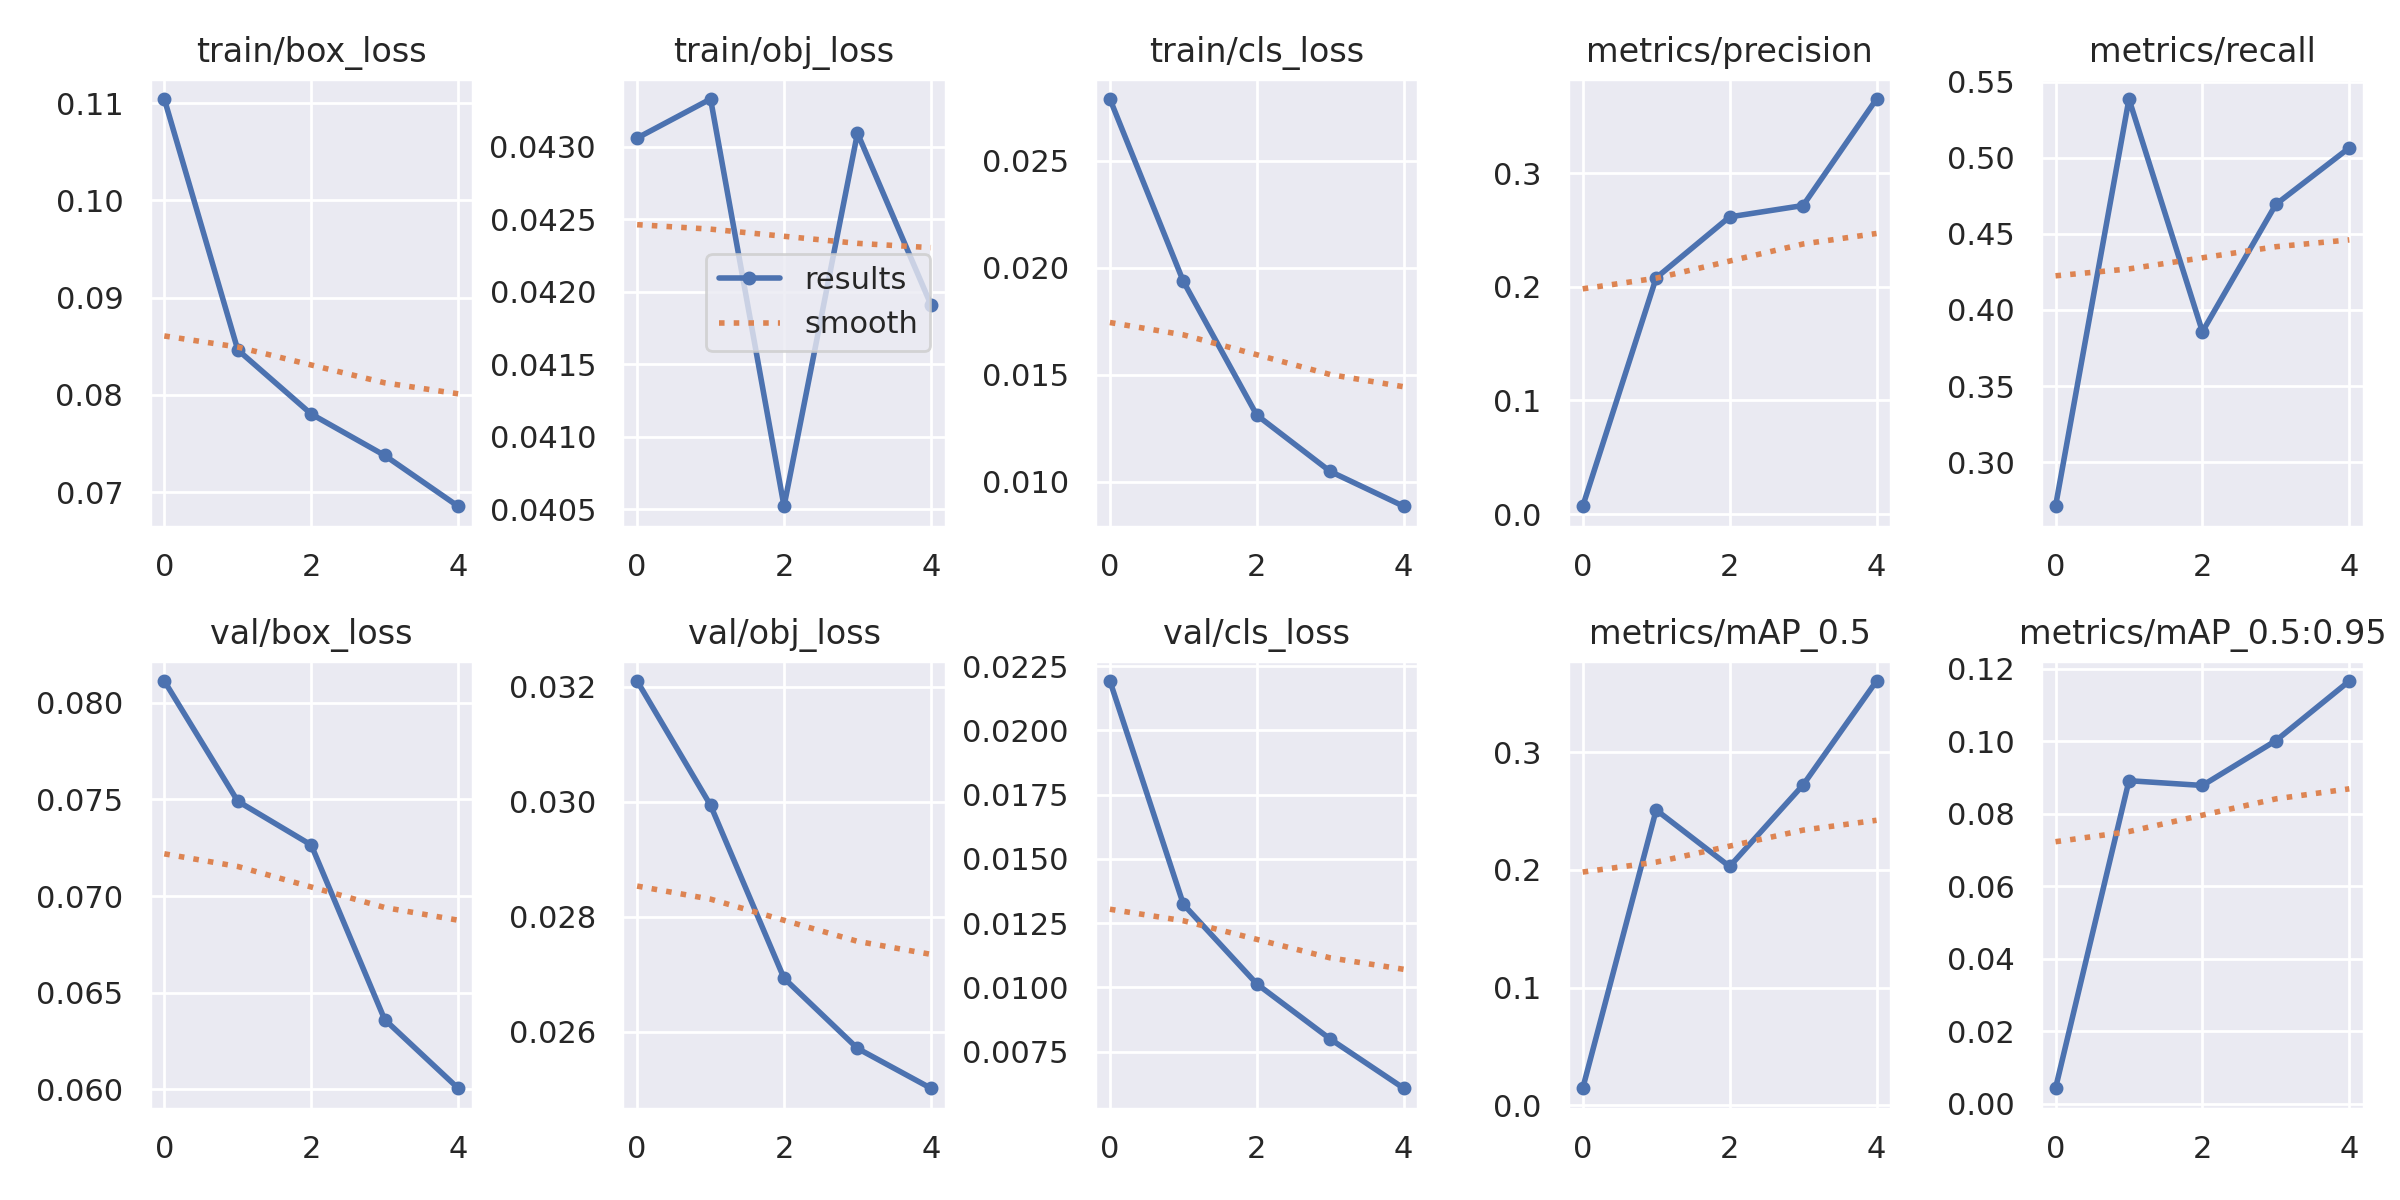

In [2]:
from IPython.display import Image

Image(filename='./runs/train/exp20/results.png', width=1000)

As we can notice model still can improved

So we training same model with freezing first 15 layers

In [ ]:
!python train.py --freeze 15 --img 640 --batch 8 --epochs 5 --data ./data/data_fold/data.yaml

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-17 17:30:34.021827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 17:30:34.073653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 17:30:34.089657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

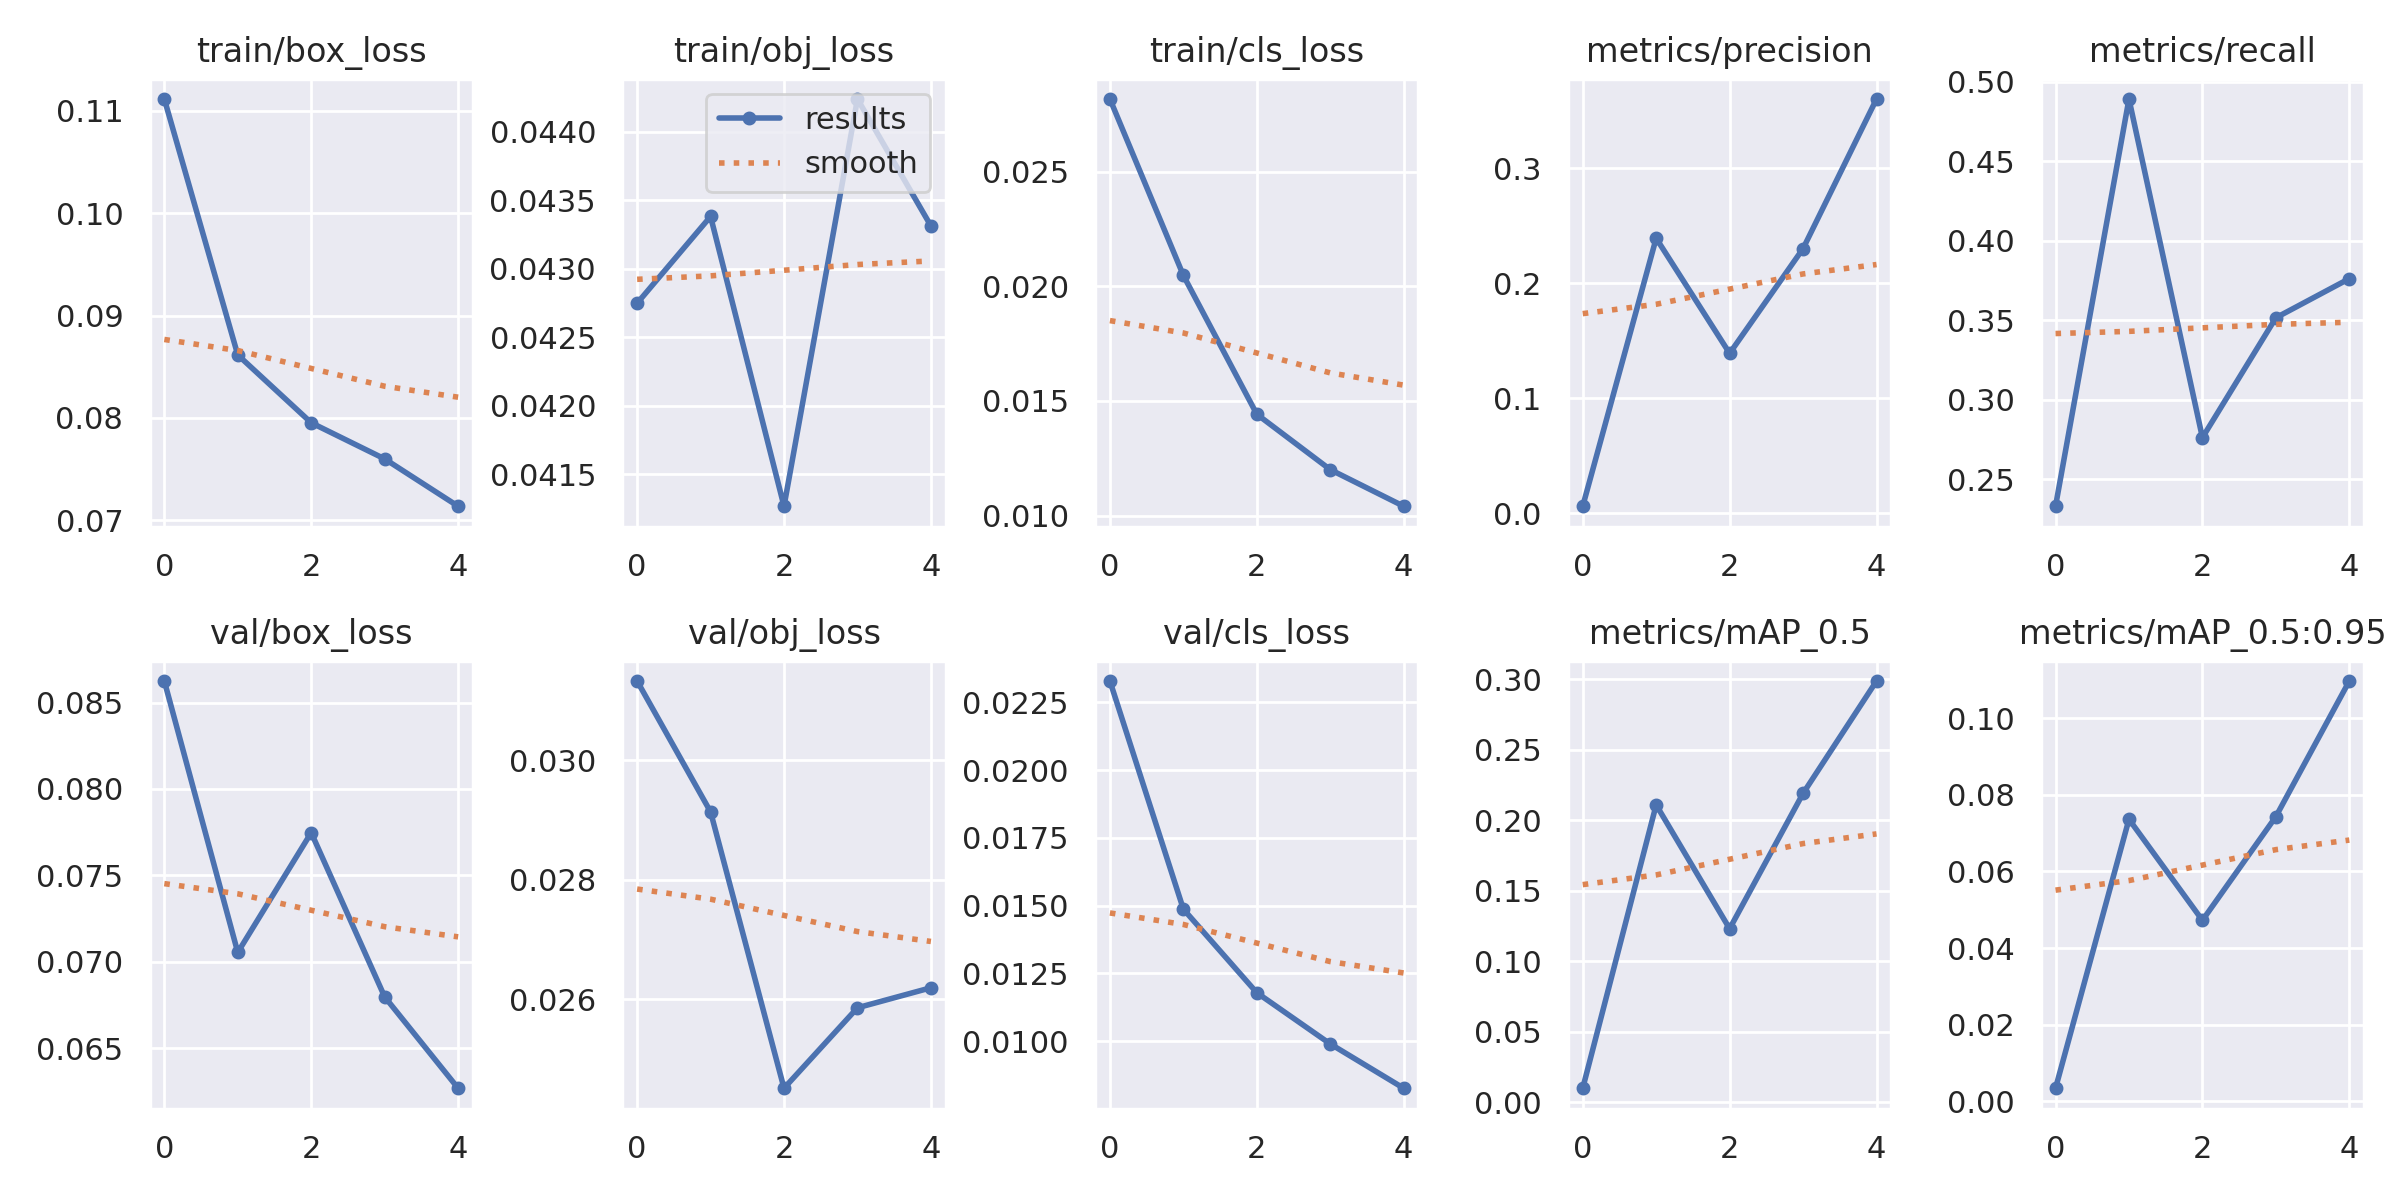

In [ ]:
Image(filename='./runs/train/exp21/results.png', width=1000)

Model tuning with 18 freezing layers

In [ ]:
!python train.py --freeze 18 --img 640 --batch 8 --epochs 5 --data ./data/data_fold/data.yaml

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-17 18:10:30.254985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 18:10:30.287996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 18:10:30.298234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

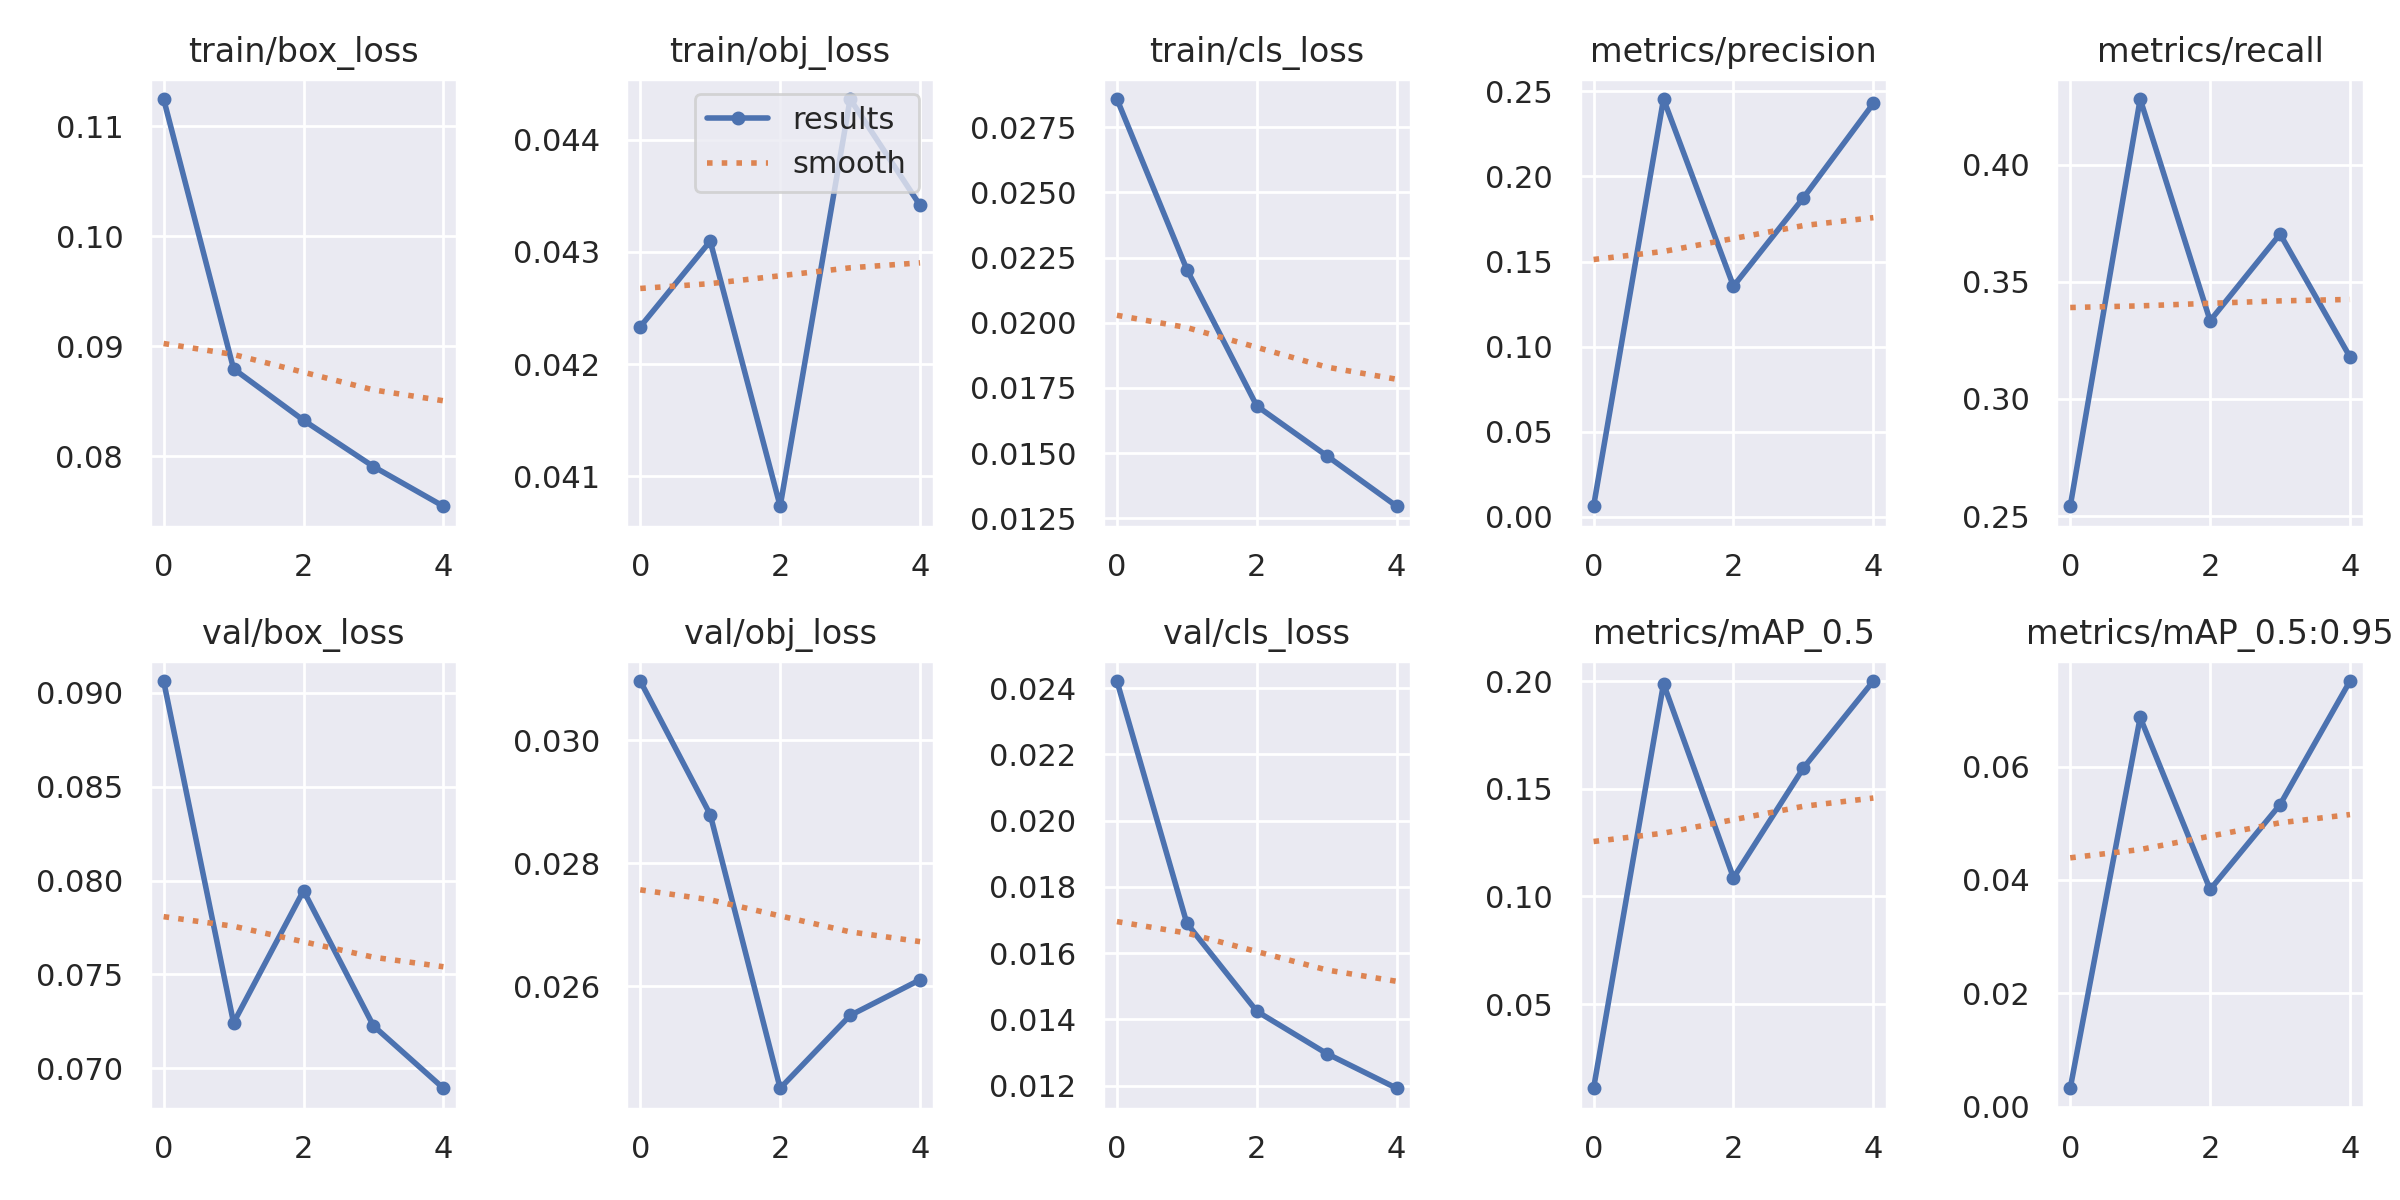

In [ ]:
Image(filename='./runs/train/exp22/results.png', width=1000)

BY freezing more layers we are loosing precision recall and iou score so we decrease no fo freezing layers  to first 5

In [ ]:
!python train.py --freeze 5 --img 640 --batch 8 --epochs 5 --data ./data/data_fold/data.yaml

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-17 18:55:22.231362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 18:55:22.267091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 18:55:22.277782: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

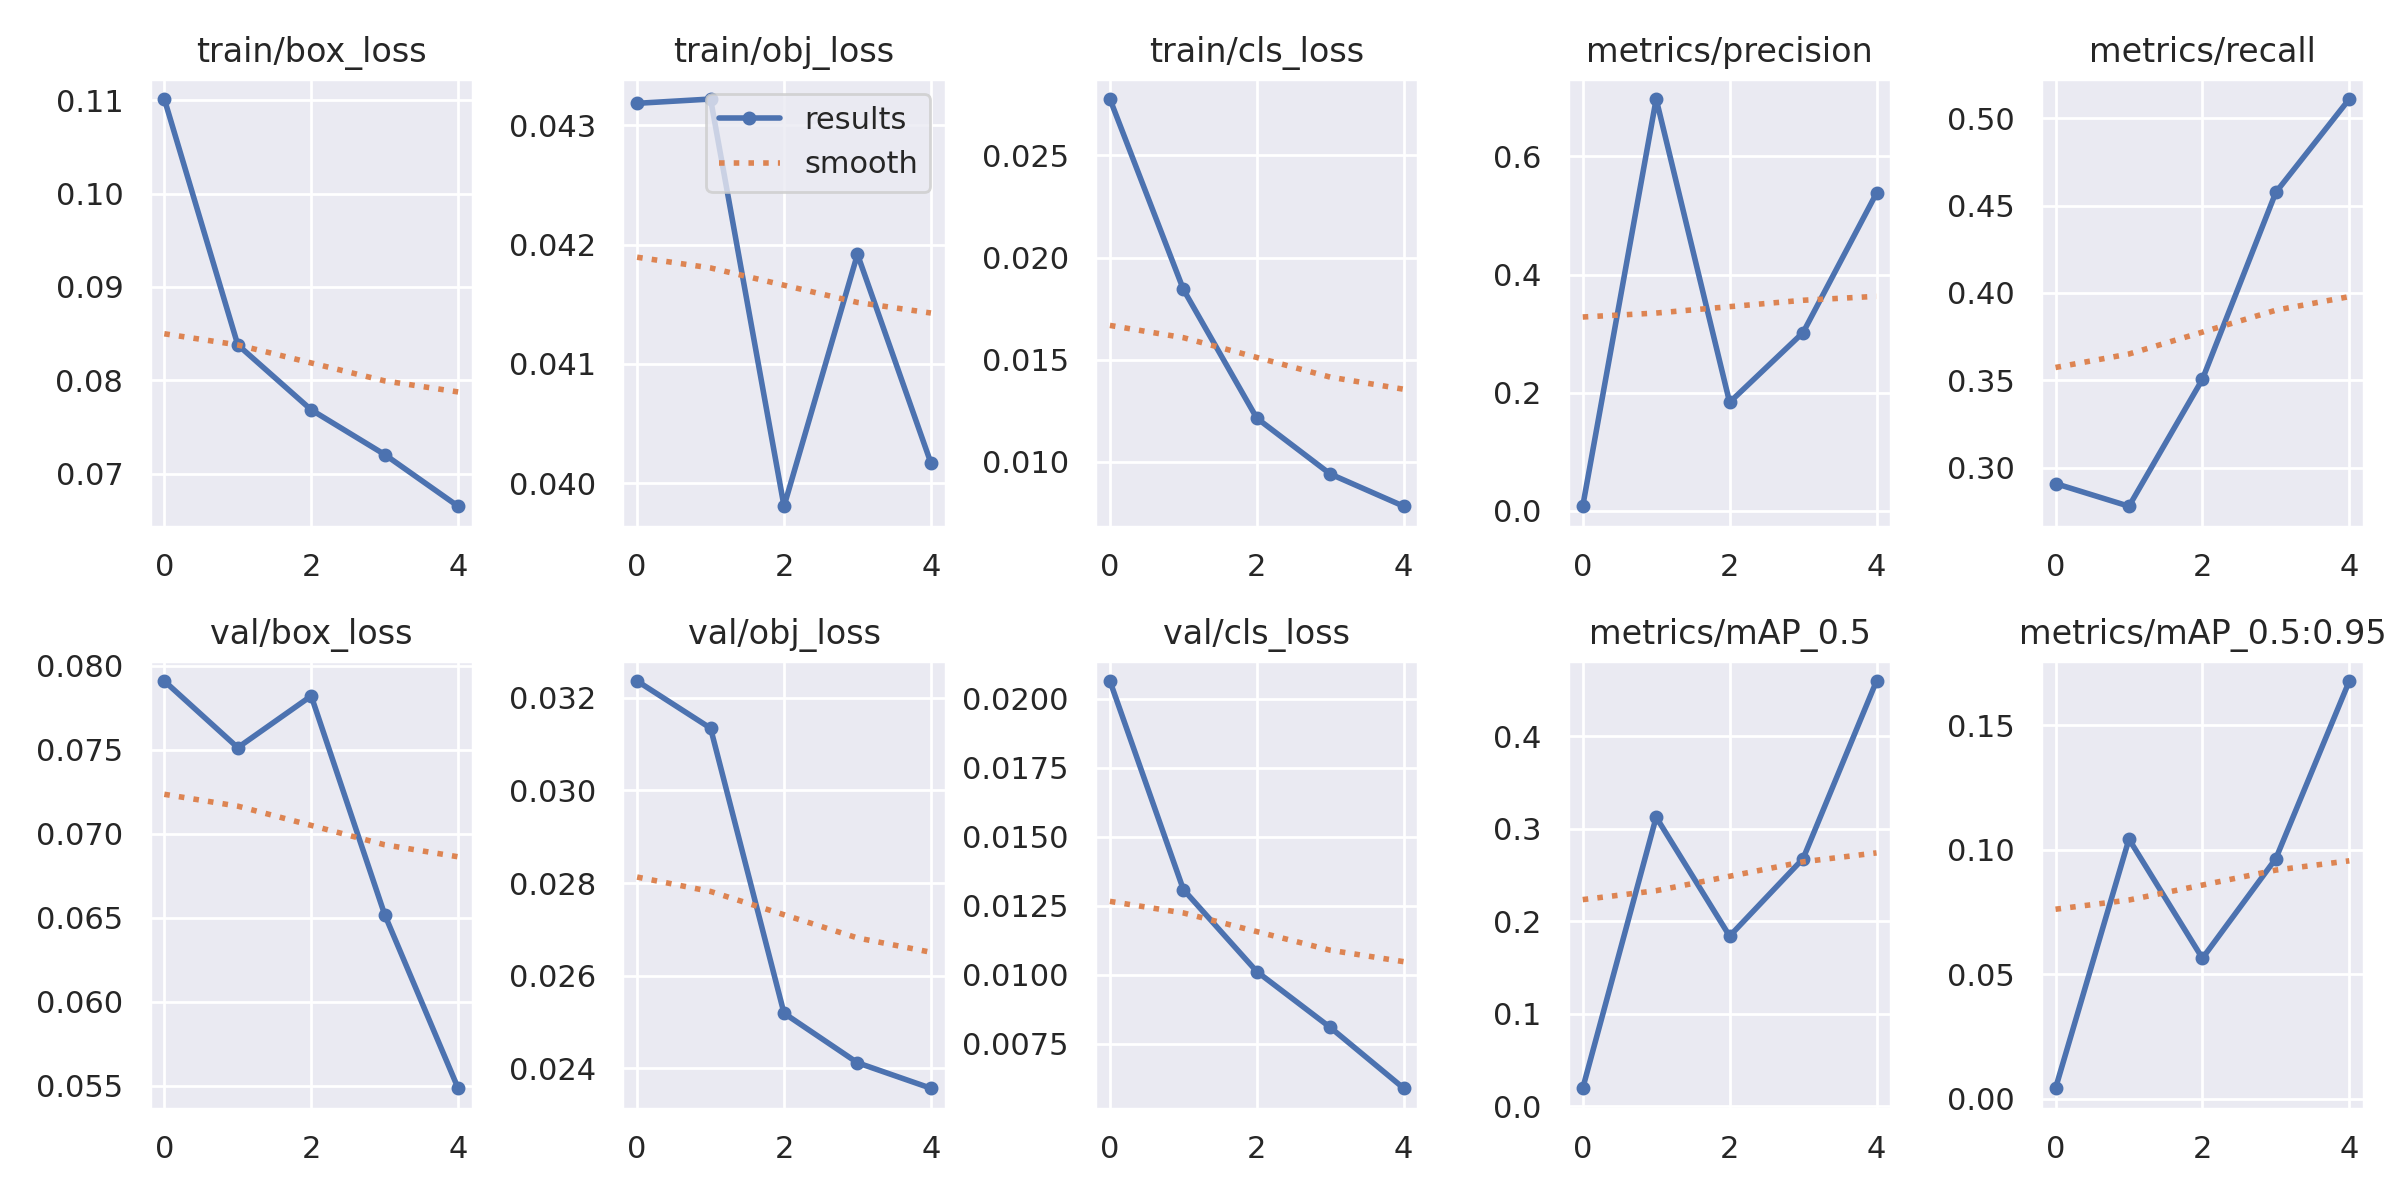

In [ ]:
Image(filename='./runs/train/exp23/results.png', width=1000)

As we now the model is performing better than previous models with precision and recall at near 50 and iou of 16 so increase epchos to 10

In [ ]:
!python train.py --freeze 5 --img 640 --batch 8 --epochs 10 --data ./data/data_fold/data.yaml

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-17 19:36:59.470199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 19:36:59.512571: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 19:36:59.526249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

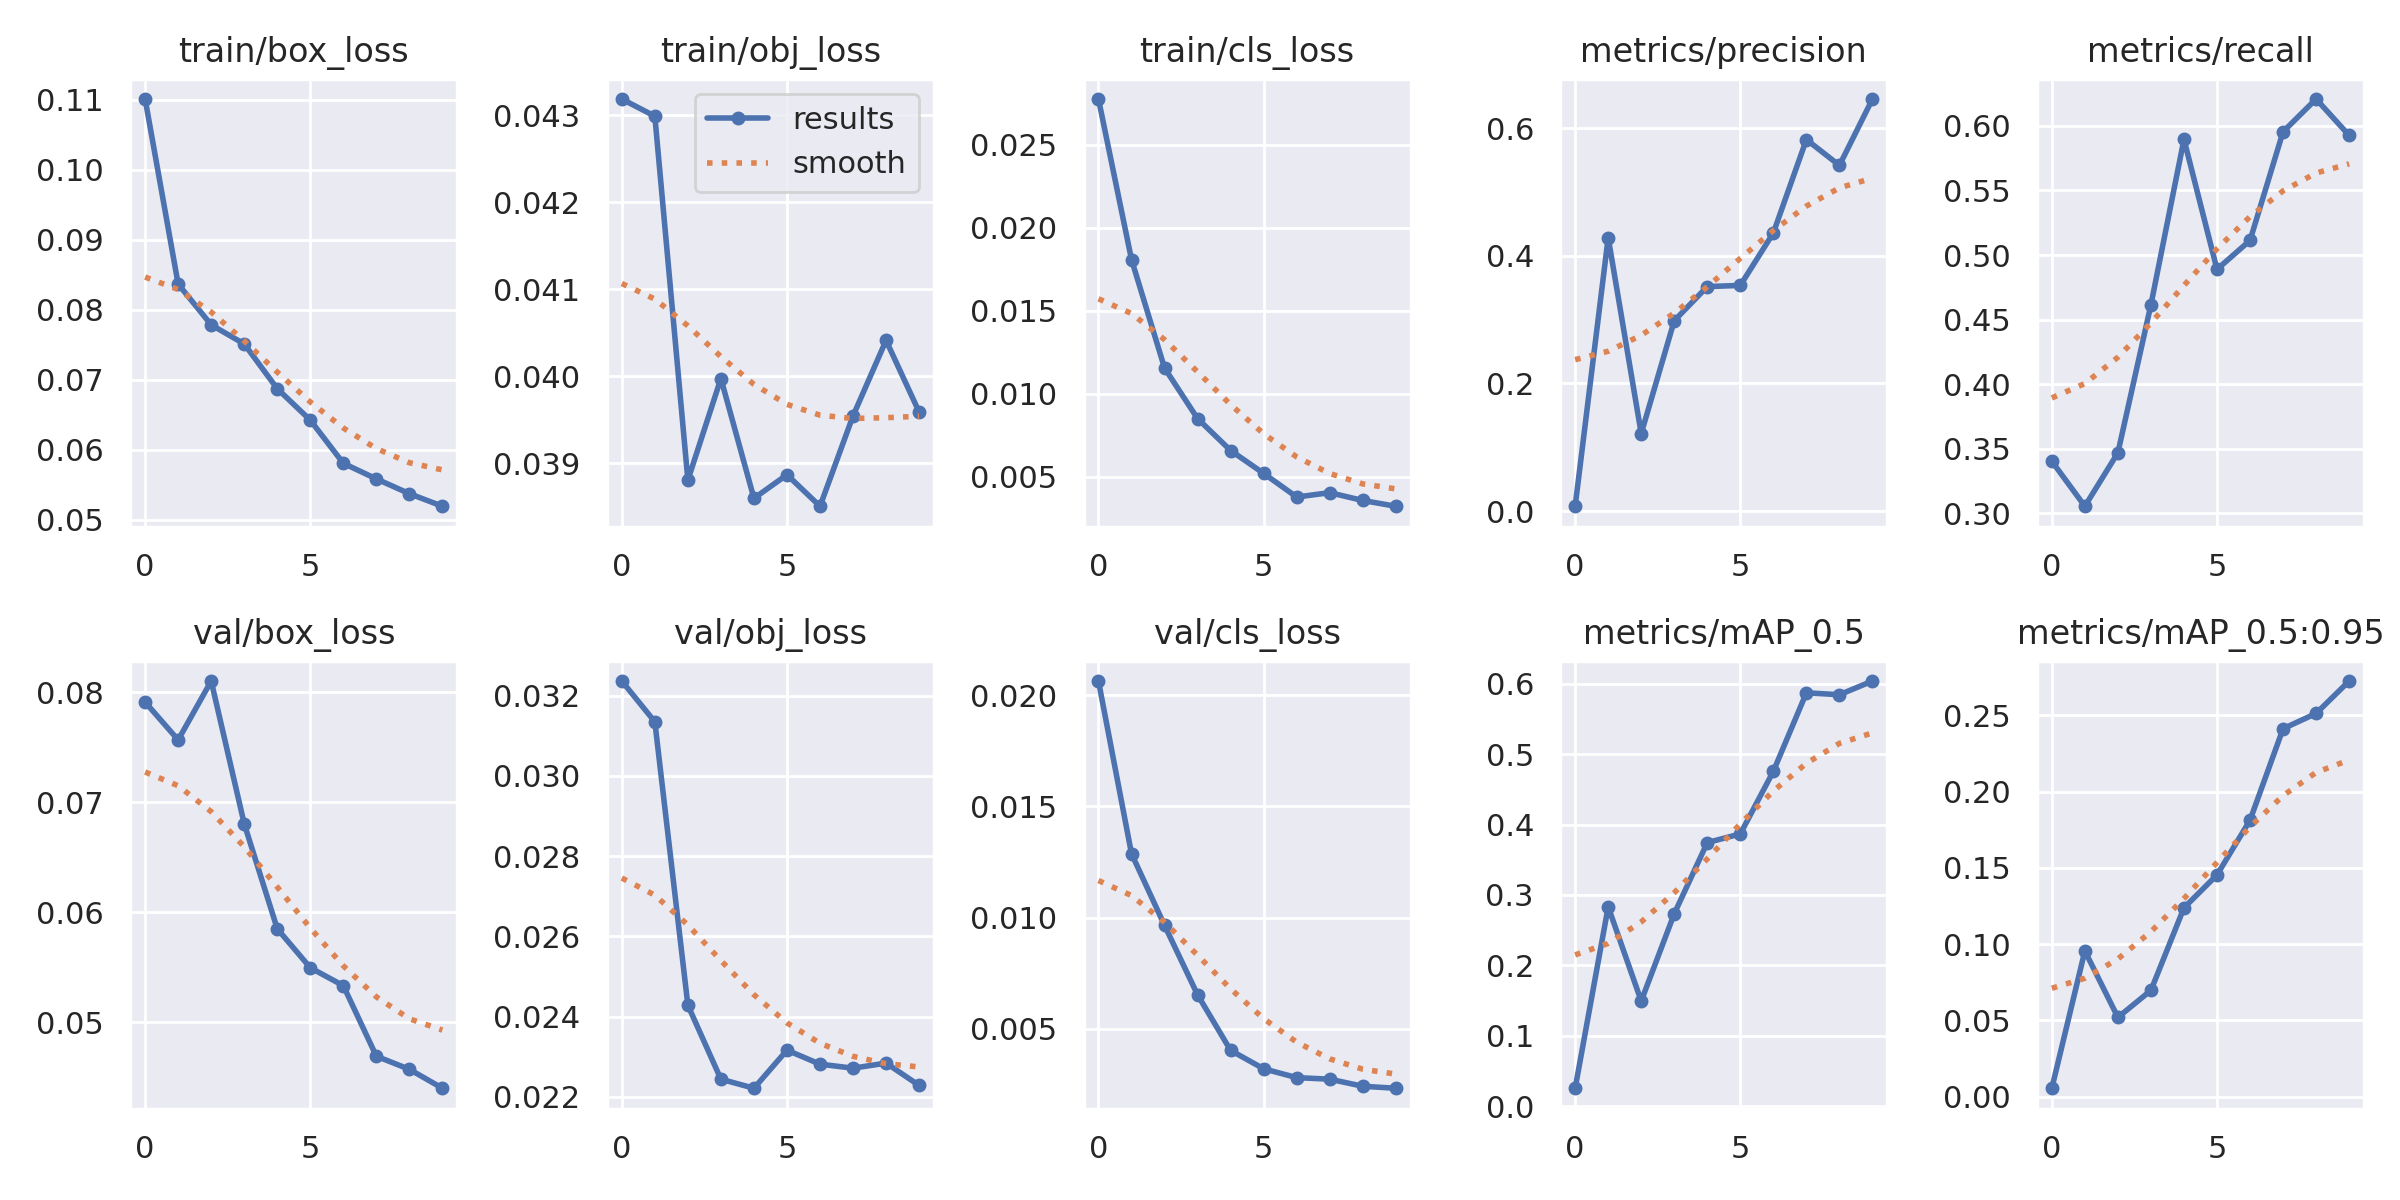

In [ ]:
Image(filename='./runs/train/exp24/results.png', width=1000)

In [ ]:
!python train.py --img 640 --batch 8 --epochs 10 --data ./data/data_fold/data.yaml

train: weights=yolov5s.pt, cfg=, data=./data/data_fold/data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=10, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github:  YOLOv5 is out of date by 2867 commits. Use 'git pull ultralytics master' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5  c7938116 Python-3.9.0 torch-2.5.1+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8

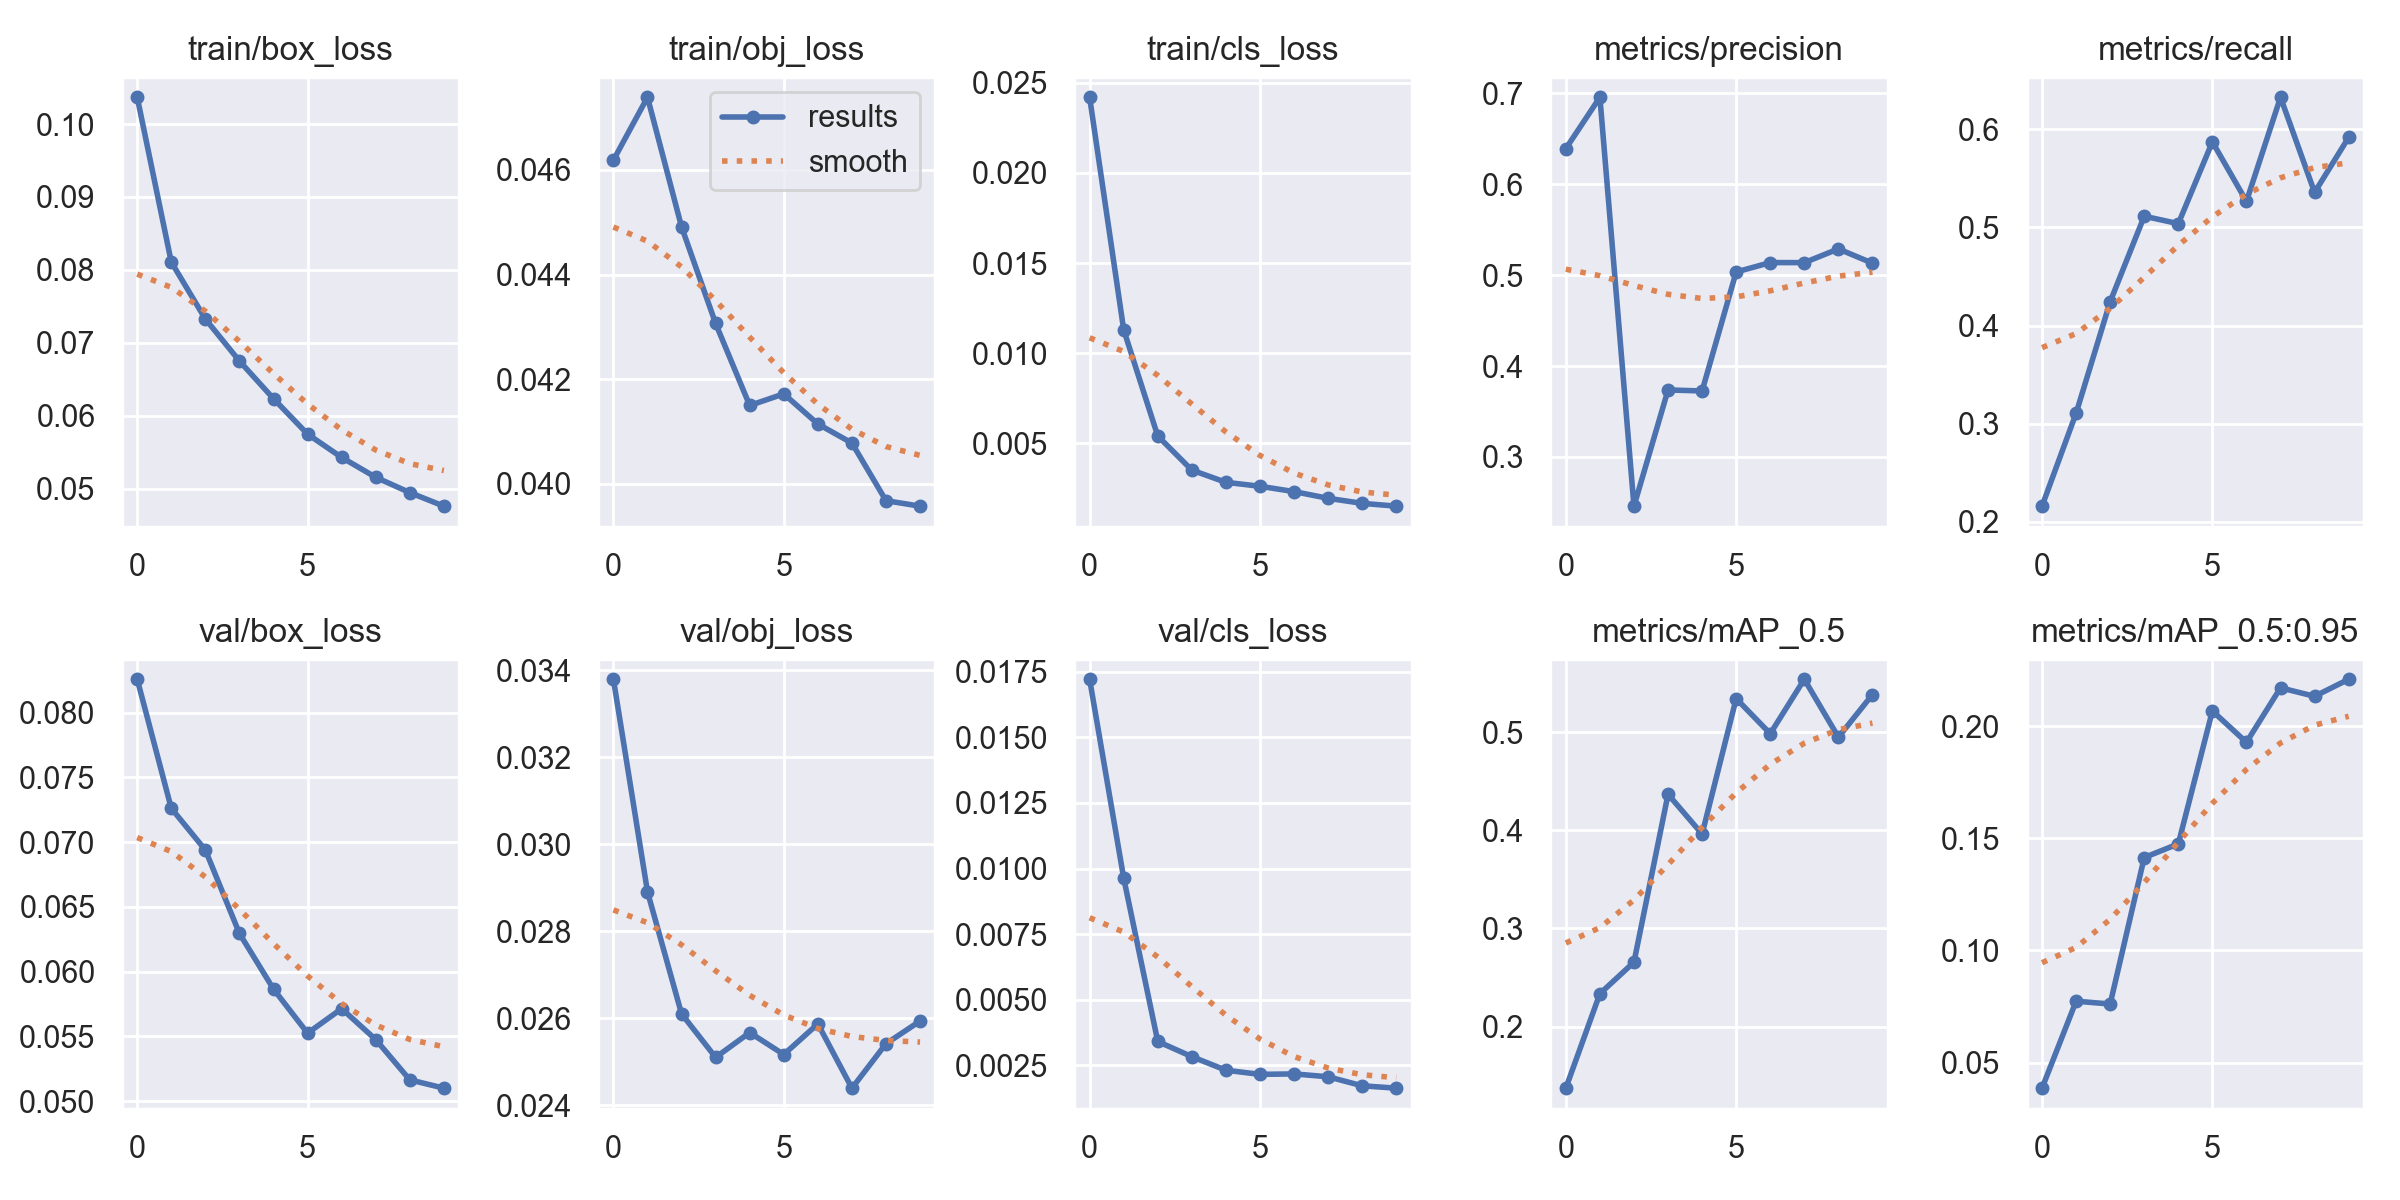

In [2]:
from IPython.display import Image

Image(filename='./runs/train/exp28/results.png', width=1000)

In [7]:
!python train.py --img 640 --batch 8 --epochs 20 --data ./data/data_fold/data.yaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.2/887.2 kB 53.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-18 20:24:16.217024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 20:24:16.236479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 20:24:16.242431

In [8]:
!python train.py --img 640 --batch 8 --epochs 10 --data ./data/data_fold/data.yaml --weights ./runs/train/exp/weights/best.pt

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-18 21:06:39.613400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 21:06:39.633733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 21:06:39.641149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

### We trained the above model for 30 epochs it making overfitting model to the data so we reduce the no of epochs 

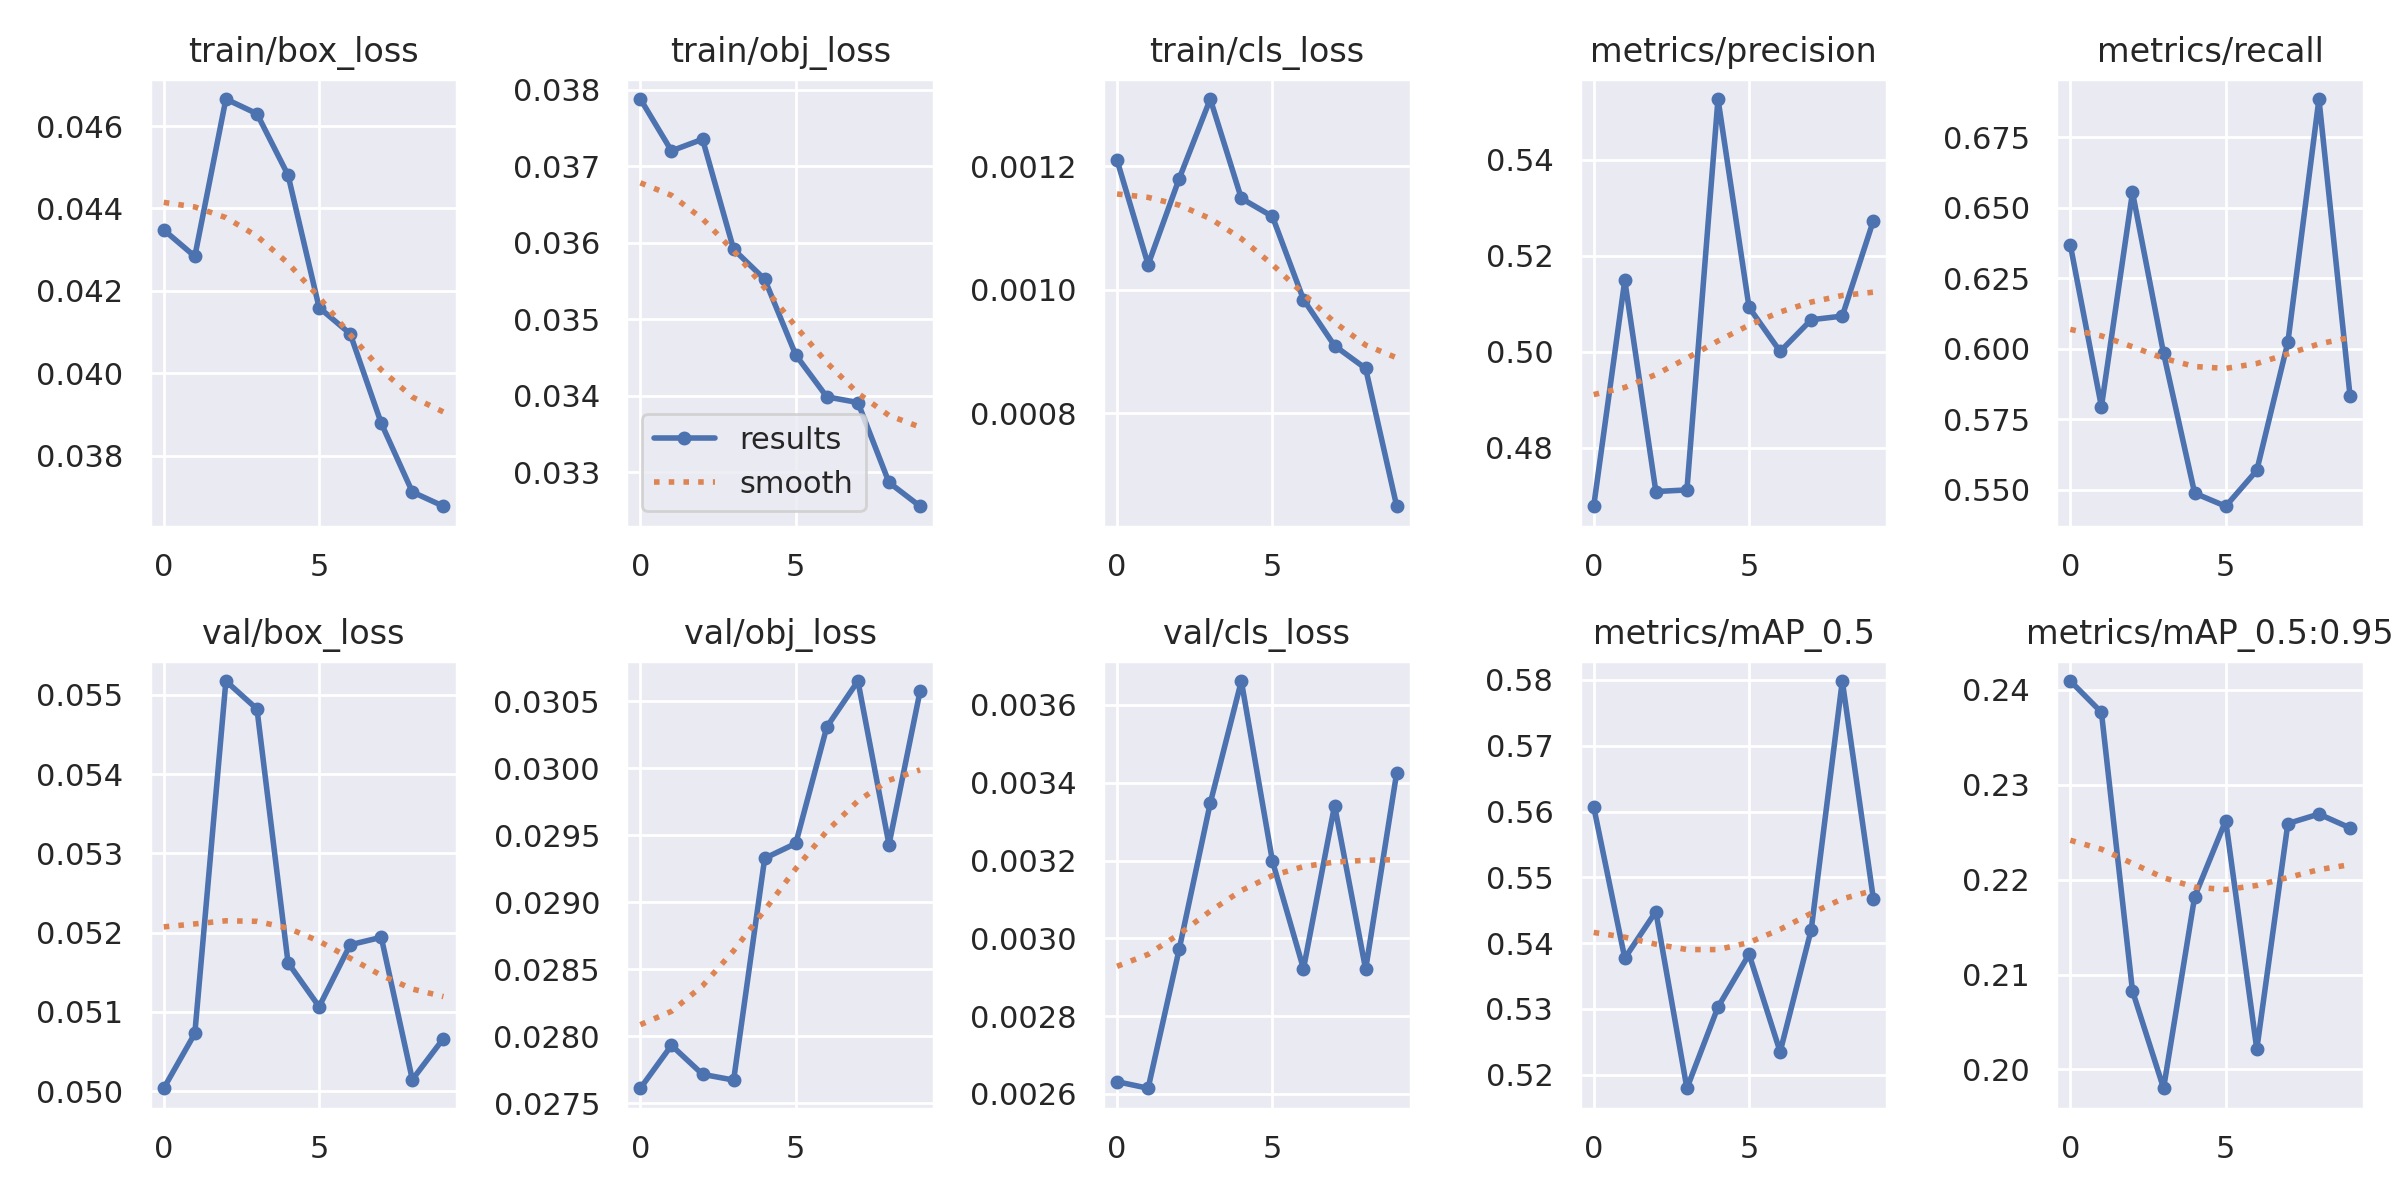

In [3]:
from IPython.display import Image

Image(filename='./runs/train/exp2/results.png', width=1000)

In [9]:
!python train.py --img 640 --batch 8 --epochs 5 --data ./data/data_fold/data.yaml

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-18 21:17:03.269647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 21:17:03.305235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 21:17:03.317907: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

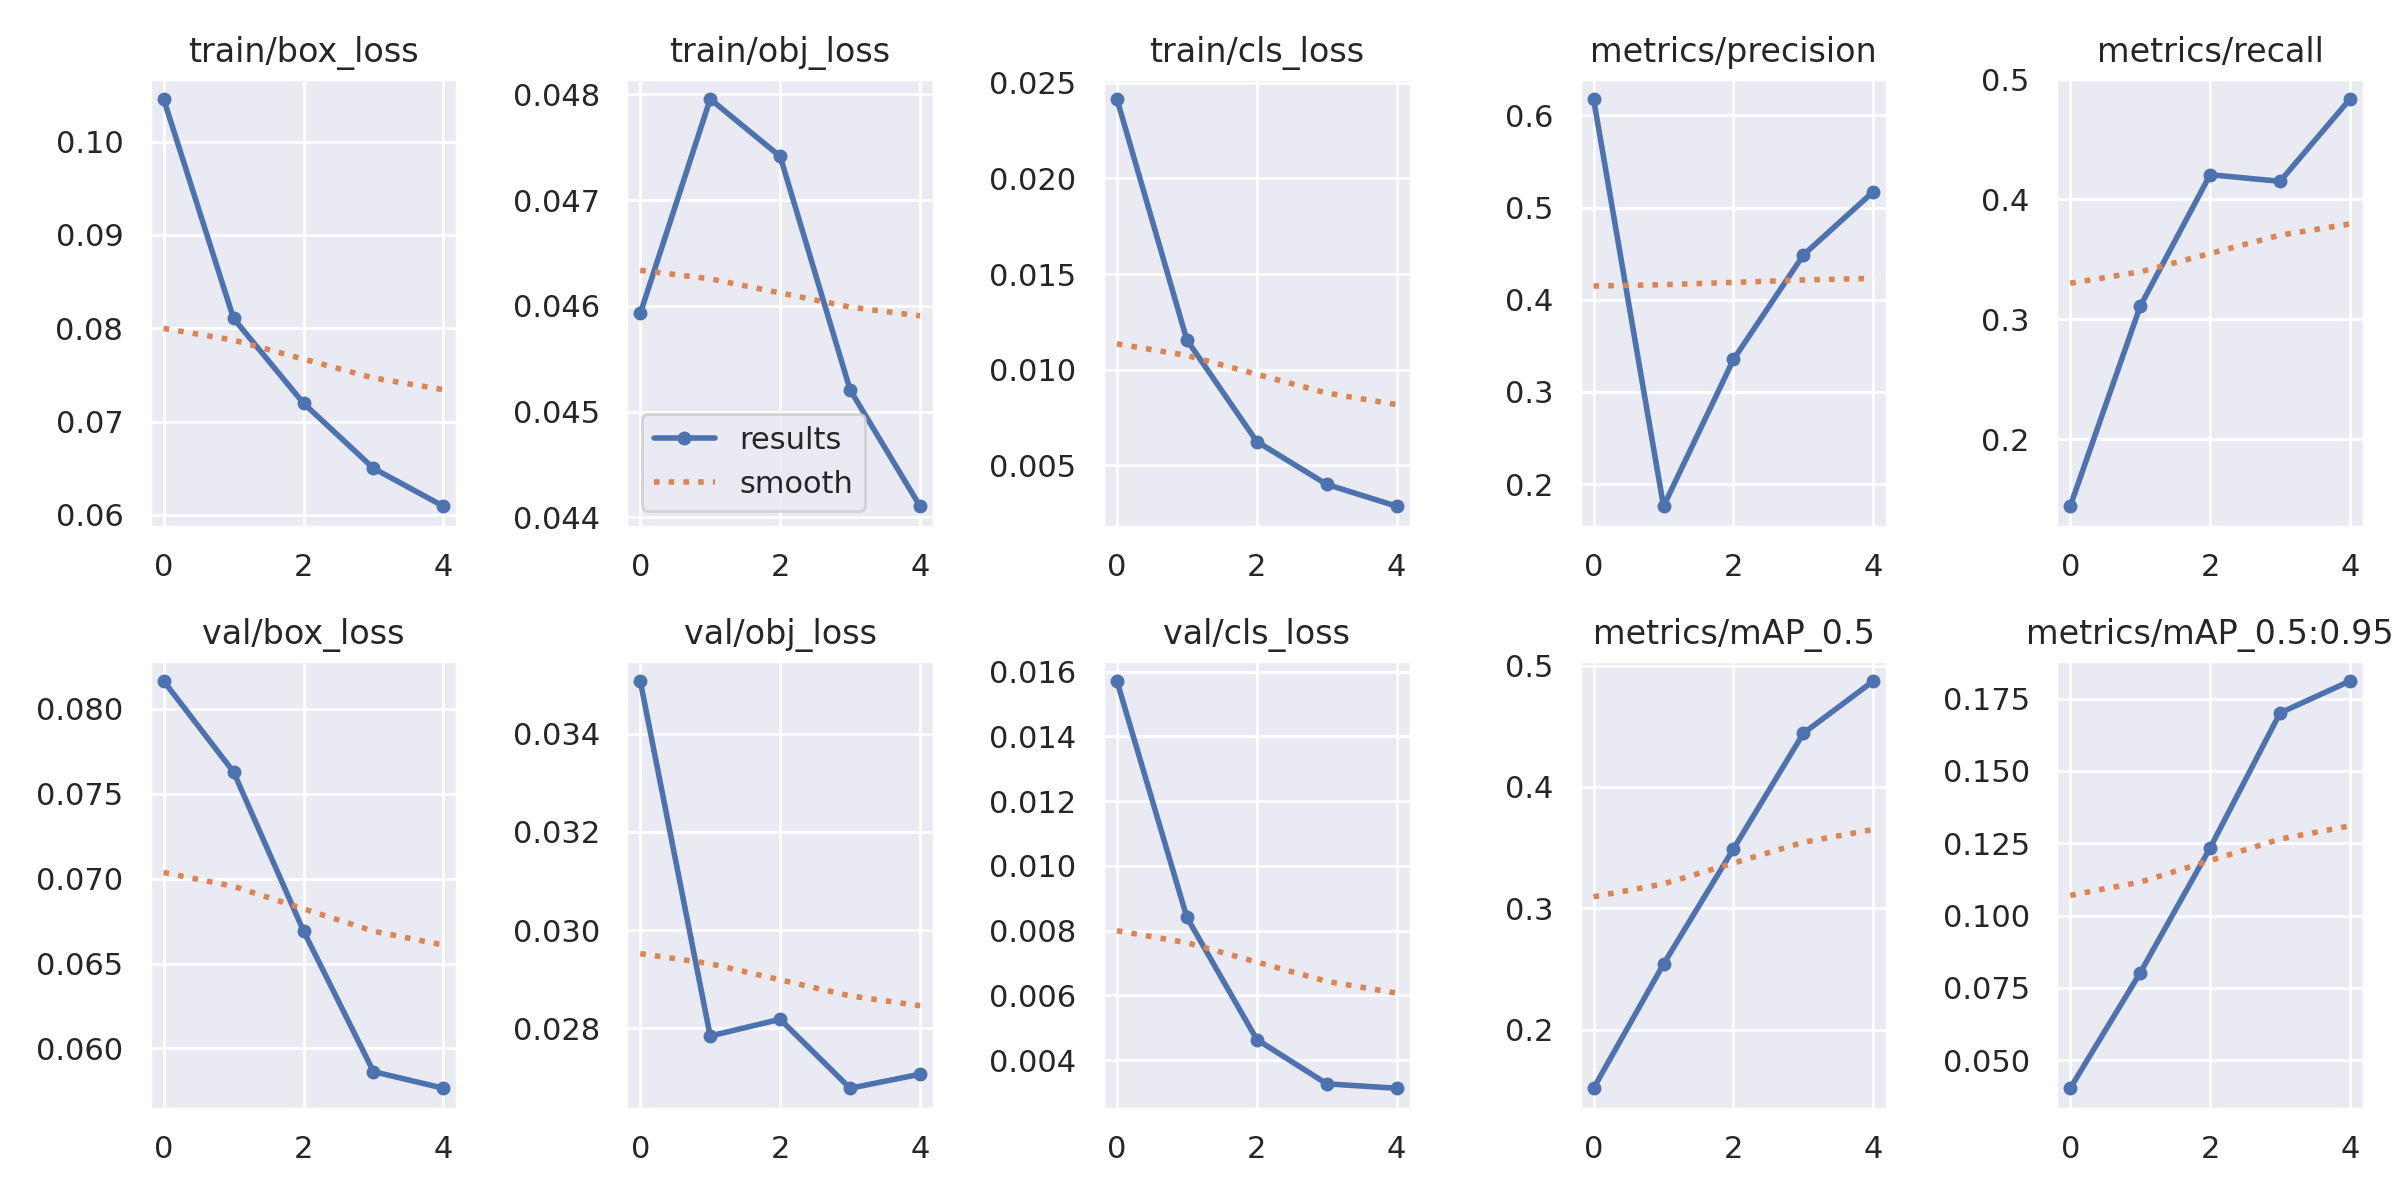

In [4]:
from IPython.display import Image

Image(filename='./runs/train/exp3/results.png', width=1000)

## We are choosing this model as it performing generalized better on useen data